色々な人工データを作って、提案手法と他の指標でシミュレーションをする

人工データ:
- sparse性: R = [100, 300, 500]
- cluster性の強さ: \alpha = [5, 10, 50]
- clusterの数: N_C, n_c = [5, 25], [10, 50] [20, 100]

結果:
- simulationの図
- 表

In [38]:
import classopt
import pathlib
import pandas as pd
import numpy as np

from lib.criterion import InformationGainCriterion
from lib.const import PREPRINT_METHODS
from lib.data import generate_artificial_dataset
from simulation import simulation
from util import generate_psi_from_dataset


@classopt.classopt(default_long=True)
class Args:
    data_path: str = classopt.config(default=None)
    out_dir: str = classopt.config(required=True)
    methods: list[str] = classopt.config(required=True)
    mode: str = "valid"
    seed: int = 0
    topic_nums: int = 50
    trial_nums: int = 5
    iter_max: int = 50
    total_round: int = 100
    num_psi: int = 1_000
    eps: float = 0.0
    psi_strategy: str = classopt.config(
        choices=["bernoulli", "embedding"], default="bernoulli"
    )

    def __post_init__(self) -> None:
        self.out_path = pathlib.Path(self.out_dir)
        self.out_path.mkdir(parents=True, exist_ok=True)
        print(f"output to: {self.out_path}")

In [39]:
def run(
    alpha: float,
    num_sample_item: int,
    num_topic: tuple[int, int],
    log_dir: pathlib.Path,
) -> None:
    log_dir.mkdir(parents=True, exist_ok=True)
    args = Args.from_dict(
        {
            "out_dir": "log/rebuttal",
            "methods": PREPRINT_METHODS,
            "mode": "valid",
            "seed": 0,
            "topic_nums": 50,
            "trial_nums": 5,
            "iter_max": 50,
            "total_round": 100,
            "num_psi": 1_000,
            "eps": 0.0,
            "psi_strategy": "bernoulli",
        }
    )
    print("args:", args)

    dataset = generate_artificial_dataset(
        num_user=5000,
        num_item=1000,
        num_topic=num_topic[1],
        num_u_topic=num_topic[0],
        num_k=20,
        num_topic_per_k=10,
        num_sample_item=num_sample_item,
        alpha=alpha,
        random_state=0,
    )
    psi, weights = generate_psi_from_dataset(
        strategy=args.psi_strategy,
        dataset=dataset,
        topic_nums=args.topic_nums,
        iter_max=args.iter_max,
        rnd=np.random.RandomState(args.seed),
        num_new_psi=args.num_psi,
    )
    model = InformationGainCriterion(psi=psi, weights=weights, eps=args.eps)
    log_datas: list[dict] = []

    for method in args.methods:
        print(f"simulate: {method}")
        for seed in range(args.trial_nums):
            log_data = simulation(
                method=method,
                model=model,
                dataset=dataset,
                total_round=args.total_round,
                seed=args.seed + seed,
                metrics=args.methods,
                verbose=False,
            )
            print(log_data[-1])
            log_datas.extend(log_data)
    df = pd.DataFrame(log_datas)
    df.to_csv(log_dir / "log.csv", index=False)


alphas = [5.0, 10.0, 50.0]  # alpha
num_sample_items = [300, 500, 700]  # R
num_topics = [(5, 25), (10, 50), (20, 100)]  # (N_C, N_c)

log_dirs = []
log_dirs.append([])
for alpha in alphas:
    log_dir = pathlib.Path(f"log/rebuttal/alpha_{alpha}")
    log_dirs[-1].append(log_dir)
    run(
        alpha=alpha,
        num_sample_item=500,
        num_topic=(10, 50),
        log_dir=log_dir,
    )

log_dirs.append([])
for num_sample_item in num_sample_items:
    log_dir = pathlib.Path(f"log/rebuttal/num_sample_item_{num_sample_item}")
    log_dirs[-1].append(log_dir)
    run(
        alpha=10.0,
        num_sample_item=num_sample_item,
        num_topic=(10, 50),
        log_dir=log_dir,
    )

log_dirs.append([])
for num_topic in num_topics:
    log_dir = pathlib.Path(f"log/rebuttal/num_topic_{num_topic[0]}_{num_topic[1]}")
    log_dirs[-1].append(log_dir)
    run(
        alpha=10.0,
        num_sample_item=500,
        num_topic=num_topic,
        log_dir=log_dir,
    )

output to: log/rebuttal
args: Args(data_path=None, out_dir='log/rebuttal', methods=['accuracy', 'diversity:topic:category', 'novelty:ip', 'serendipity:topic:category', 'information-gain'], mode='valid', seed=0, topic_nums=50, trial_nums=5, iter_max=50, total_round=100, num_psi=1000, eps=0.0, psi_strategy='bernoulli')
create-topic-cluster:start


100%|██████████| 5000/5000 [00:09<00:00, 543.88it/s]


create-topic-cluster:end


100%|██████████| 5000/5000 [00:00<00:00, 68062.39it/s]

self.user_n=5000 self.item_n=1000
total_train_p_u: 649671
total_train_r_u: 2500000
total_eval_p_u: 649961
total_eval_r_u: 2500000
item_topics:
    topic: category, count: 50
    topic: category-u, count: 10
    topic: latent-cluster, count: 50



 38%|███▊      | 19/50 [01:26<02:21,  4.57s/it, log L=-3.16e+8]


early break at: 19
simulate: accuracy


100%|██████████| 100/100 [00:00<00:00, 105.16it/s]


{'method': 'accuracy', 'seed': 0, 'round': 100, 'item': 823, 'test-recall': 0.4927536231884058, 'hit': 0.6964285714285714, 'entropy': 1.815039842603988, 'accuracy': 0.6964285714285714, 'diversity:topic:category': 0.9783838383838384, 'novelty:ip': 0.304108998703866, 'serendipity:topic:category': 0.39, 'information-gain': 0.2474229965922332}


100%|██████████| 100/100 [00:00<00:00, 108.11it/s]


{'method': 'accuracy', 'seed': 1, 'round': 100, 'item': 260, 'test-recall': 0.44594594594594594, 'hit': 0.6582278481012658, 'entropy': 4.261793528790764, 'accuracy': 0.6582278481012658, 'diversity:topic:category': 0.956969696969697, 'novelty:ip': 0.40959538221364816, 'serendipity:topic:category': 0.52, 'information-gain': 0.2737022630873276}


100%|██████████| 100/100 [00:01<00:00, 83.26it/s]


{'method': 'accuracy', 'seed': 2, 'round': 100, 'item': 490, 'test-recall': 0.4, 'hit': 0.5882352941176471, 'entropy': 4.012839925252986, 'accuracy': 0.5882352941176471, 'diversity:topic:category': 0.9609090909090909, 'novelty:ip': 0.4112604988310041, 'serendipity:topic:category': 0.4, 'information-gain': 0.27969978450629}


100%|██████████| 100/100 [00:00<00:00, 101.36it/s]


{'method': 'accuracy', 'seed': 3, 'round': 100, 'item': 241, 'test-recall': 0.3709677419354839, 'hit': 0.6338028169014085, 'entropy': 3.1006163948059955, 'accuracy': 0.6338028169014085, 'diversity:topic:category': 0.96, 'novelty:ip': 0.414403843653486, 'serendipity:topic:category': 0.45, 'information-gain': 0.31402312304023156}


100%|██████████| 100/100 [00:00<00:00, 140.85it/s]


{'method': 'accuracy', 'seed': 4, 'round': 100, 'item': 606, 'test-recall': 0.4576271186440678, 'hit': 0.453125, 'entropy': 0.971984066241906, 'accuracy': 0.453125, 'diversity:topic:category': 0.9708080808080808, 'novelty:ip': 0.45586134461679834, 'serendipity:topic:category': 0.29, 'information-gain': 0.20922188692911625}
simulate: diversity:topic:category


100%|██████████| 100/100 [00:00<00:00, 104.11it/s]


{'method': 'diversity:topic:category', 'seed': 0, 'round': 100, 'item': 981, 'test-recall': 0.5072463768115942, 'hit': 0.23214285714285715, 'entropy': 1.7659593314925441, 'accuracy': 0.23214285714285715, 'diversity:topic:category': 0.9948484848484849, 'novelty:ip': 0.6909175274236067, 'serendipity:topic:category': 0.13, 'information-gain': 0.09761907121616771}


100%|██████████| 100/100 [00:00<00:00, 104.31it/s]


{'method': 'diversity:topic:category', 'seed': 1, 'round': 100, 'item': 991, 'test-recall': 0.40540540540540543, 'hit': 0.189873417721519, 'entropy': 5.199113700517321, 'accuracy': 0.189873417721519, 'diversity:topic:category': 0.9948484848484849, 'novelty:ip': 0.6901994053701535, 'serendipity:topic:category': 0.15, 'information-gain': 0.10367644376849587}


100%|██████████| 100/100 [00:00<00:00, 113.05it/s]


{'method': 'diversity:topic:category', 'seed': 2, 'round': 100, 'item': 985, 'test-recall': 0.36923076923076925, 'hit': 0.19117647058823528, 'entropy': 3.9708787275904163, 'accuracy': 0.19117647058823528, 'diversity:topic:category': 0.9948484848484849, 'novelty:ip': 0.6915255734951558, 'serendipity:topic:category': 0.13, 'information-gain': 0.09662941959815796}


100%|██████████| 100/100 [00:00<00:00, 104.85it/s]


{'method': 'diversity:topic:category', 'seed': 3, 'round': 100, 'item': 983, 'test-recall': 0.43548387096774194, 'hit': 0.2112676056338028, 'entropy': 3.402431805728719, 'accuracy': 0.2112676056338028, 'diversity:topic:category': 0.9948484848484849, 'novelty:ip': 0.693580157970499, 'serendipity:topic:category': 0.15, 'information-gain': 0.10844214389031218}


100%|██████████| 100/100 [00:00<00:00, 116.25it/s]


{'method': 'diversity:topic:category', 'seed': 4, 'round': 100, 'item': 984, 'test-recall': 0.3559322033898305, 'hit': 0.1875, 'entropy': 3.487832158071816, 'accuracy': 0.1875, 'diversity:topic:category': 0.9948484848484849, 'novelty:ip': 0.6877413361701591, 'serendipity:topic:category': 0.12, 'information-gain': 0.10376568136174175}
simulate: novelty:ip


100%|██████████| 100/100 [00:00<00:00, 120.38it/s]


{'method': 'novelty:ip', 'seed': 0, 'round': 100, 'item': 590, 'test-recall': 0.4492753623188406, 'hit': 0.08928571428571429, 'entropy': 6.620565579295853, 'accuracy': 0.08928571428571429, 'diversity:topic:category': 0.9541414141414142, 'novelty:ip': 1.3099543611328526, 'serendipity:topic:category': 0.05, 'information-gain': 0.04440607369491866}


100%|██████████| 100/100 [00:00<00:00, 137.29it/s]


{'method': 'novelty:ip', 'seed': 1, 'round': 100, 'item': 255, 'test-recall': 0.43243243243243246, 'hit': 0.13924050632911392, 'entropy': 5.152880906106102, 'accuracy': 0.13924050632911392, 'diversity:topic:category': 0.9517171717171717, 'novelty:ip': 1.3313429449425123, 'serendipity:topic:category': 0.11, 'information-gain': 0.06390306547329613}


100%|██████████| 100/100 [00:00<00:00, 120.87it/s]


{'method': 'novelty:ip', 'seed': 2, 'round': 100, 'item': 840, 'test-recall': 0.23076923076923078, 'hit': 0.08823529411764706, 'entropy': 5.174983829621585, 'accuracy': 0.08823529411764706, 'diversity:topic:category': 0.9532323232323232, 'novelty:ip': 1.369727012007082, 'serendipity:topic:category': 0.06, 'information-gain': 0.05669723845830969}


100%|██████████| 100/100 [00:01<00:00, 90.93it/s]


{'method': 'novelty:ip', 'seed': 3, 'round': 100, 'item': 840, 'test-recall': 0.20967741935483872, 'hit': 0.09859154929577464, 'entropy': 6.173855106929691, 'accuracy': 0.09859154929577464, 'diversity:topic:category': 0.9516161616161616, 'novelty:ip': 1.3764247813922272, 'serendipity:topic:category': 0.07, 'information-gain': 0.03813772936594059}


100%|██████████| 100/100 [00:00<00:00, 114.19it/s]


{'method': 'novelty:ip', 'seed': 4, 'round': 100, 'item': 585, 'test-recall': 0.03389830508474576, 'hit': 0.078125, 'entropy': 7.298309595319583, 'accuracy': 0.078125, 'diversity:topic:category': 0.9566666666666667, 'novelty:ip': 1.3170733150519922, 'serendipity:topic:category': 0.05, 'information-gain': 0.044495823980730445}
simulate: serendipity:topic:category


100%|██████████| 100/100 [00:00<00:00, 102.50it/s]


{'method': 'serendipity:topic:category', 'seed': 0, 'round': 100, 'item': 192, 'test-recall': 0.5072463768115942, 'hit': 0.5892857142857143, 'entropy': 0.03371814661300226, 'accuracy': 0.5892857142857143, 'diversity:topic:category': 0.9843434343434343, 'novelty:ip': 0.597281757003632, 'serendipity:topic:category': 0.33, 'information-gain': 0.22574541025759173}


100%|██████████| 100/100 [00:00<00:00, 118.23it/s]


{'method': 'serendipity:topic:category', 'seed': 1, 'round': 100, 'item': 380, 'test-recall': 0.44594594594594594, 'hit': 0.27848101265822783, 'entropy': 3.950381095129286, 'accuracy': 0.27848101265822783, 'diversity:topic:category': 0.9882828282828283, 'novelty:ip': 0.578509361734108, 'serendipity:topic:category': 0.22, 'information-gain': 0.15414649346702372}


100%|██████████| 100/100 [00:00<00:00, 122.69it/s]


{'method': 'serendipity:topic:category', 'seed': 2, 'round': 100, 'item': 828, 'test-recall': 0.4, 'hit': 0.3088235294117647, 'entropy': 3.7451123564390643, 'accuracy': 0.3088235294117647, 'diversity:topic:category': 0.9888888888888889, 'novelty:ip': 0.665502713225678, 'serendipity:topic:category': 0.21, 'information-gain': 0.1544400198029576}


100%|██████████| 100/100 [00:00<00:00, 104.23it/s]


{'method': 'serendipity:topic:category', 'seed': 3, 'round': 100, 'item': 385, 'test-recall': 0.41935483870967744, 'hit': 0.23943661971830985, 'entropy': 3.559566719286587, 'accuracy': 0.23943661971830985, 'diversity:topic:category': 0.9813131313131314, 'novelty:ip': 0.42963584156237355, 'serendipity:topic:category': 0.17, 'information-gain': 0.12202297994758574}


100%|██████████| 100/100 [00:00<00:00, 127.97it/s]


{'method': 'serendipity:topic:category', 'seed': 4, 'round': 100, 'item': 322, 'test-recall': 0.4406779661016949, 'hit': 0.359375, 'entropy': 0.013750157105523284, 'accuracy': 0.359375, 'diversity:topic:category': 0.9873737373737373, 'novelty:ip': 0.7022425676170748, 'serendipity:topic:category': 0.23, 'information-gain': 0.16512554212758096}
simulate: information-gain


100%|██████████| 100/100 [00:04<00:00, 21.98it/s]


{'method': 'information-gain', 'seed': 0, 'round': 100, 'item': 31, 'test-recall': 0.5072463768115942, 'hit': 0.32142857142857145, 'entropy': 0.02581086220476042, 'accuracy': 0.32142857142857145, 'diversity:topic:category': 0.9848484848484849, 'novelty:ip': 0.45232081693591014, 'serendipity:topic:category': 0.18, 'information-gain': 0.14119911063710128}


100%|██████████| 100/100 [00:04<00:00, 20.71it/s]


{'method': 'information-gain', 'seed': 1, 'round': 100, 'item': 388, 'test-recall': 0.44594594594594594, 'hit': 0.11392405063291139, 'entropy': 3.465814911806384, 'accuracy': 0.11392405063291139, 'diversity:topic:category': 0.9878787878787879, 'novelty:ip': 0.6574253093224346, 'serendipity:topic:category': 0.09, 'information-gain': 0.06290987755201258}


100%|██████████| 100/100 [00:05<00:00, 16.98it/s]


{'method': 'information-gain', 'seed': 2, 'round': 100, 'item': 53, 'test-recall': 0.4153846153846154, 'hit': 0.29411764705882354, 'entropy': 0.03098601011182244, 'accuracy': 0.29411764705882354, 'diversity:topic:category': 0.9881818181818182, 'novelty:ip': 0.6121310405865864, 'serendipity:topic:category': 0.2, 'information-gain': 0.16639350139267592}


100%|██████████| 100/100 [00:06<00:00, 16.54it/s]


{'method': 'information-gain', 'seed': 3, 'round': 100, 'item': 290, 'test-recall': 0.3870967741935484, 'hit': 0.1267605633802817, 'entropy': 3.05228104862581, 'accuracy': 0.1267605633802817, 'diversity:topic:category': 0.9791919191919192, 'novelty:ip': 0.3427273941925285, 'serendipity:topic:category': 0.09, 'information-gain': 0.08321953314334748}


100%|██████████| 100/100 [00:05<00:00, 16.75it/s]


{'method': 'information-gain', 'seed': 4, 'round': 100, 'item': 748, 'test-recall': 0.423728813559322, 'hit': 0.234375, 'entropy': 2.4214767943831665, 'accuracy': 0.234375, 'diversity:topic:category': 0.9864646464646465, 'novelty:ip': 0.49231130294729075, 'serendipity:topic:category': 0.15, 'information-gain': 0.12782683187180427}
output to: log/rebuttal
args: Args(data_path=None, out_dir='log/rebuttal', methods=['accuracy', 'diversity:topic:category', 'novelty:ip', 'serendipity:topic:category', 'information-gain'], mode='valid', seed=0, topic_nums=50, trial_nums=5, iter_max=50, total_round=100, num_psi=1000, eps=0.0, psi_strategy='bernoulli')
create-topic-cluster:start


100%|██████████| 5000/5000 [00:08<00:00, 576.90it/s]


create-topic-cluster:end


100%|██████████| 5000/5000 [00:00<00:00, 90894.01it/s]

self.user_n=5000 self.item_n=1000
total_train_p_u: 649387
total_train_r_u: 2500000
total_eval_p_u: 648784
total_eval_r_u: 2500000
item_topics:
    topic: category, count: 50
    topic: category-u, count: 10
    topic: latent-cluster, count: 50



 64%|██████▍   | 32/50 [02:23<01:20,  4.49s/it, log L=-3.22e+8]


early break at: 32
simulate: accuracy


100%|██████████| 100/100 [00:00<00:00, 108.55it/s]


{'method': 'accuracy', 'seed': 0, 'round': 100, 'item': 933, 'test-recall': 0.25, 'hit': 0.5423728813559322, 'entropy': 3.7963989892602834, 'accuracy': 0.5423728813559322, 'diversity:topic:category': 0.9626262626262626, 'novelty:ip': 0.35795250116615646, 'serendipity:topic:category': 0.32, 'information-gain': 0.2210202058325394}


100%|██████████| 100/100 [00:00<00:00, 127.25it/s]


{'method': 'accuracy', 'seed': 1, 'round': 100, 'item': 562, 'test-recall': 0.34328358208955223, 'hit': 0.5714285714285714, 'entropy': 3.2846492143975903, 'accuracy': 0.5714285714285714, 'diversity:topic:category': 0.9701010101010101, 'novelty:ip': 0.4332787546397829, 'serendipity:topic:category': 0.44, 'information-gain': 0.3402936662787139}


100%|██████████| 100/100 [00:00<00:00, 133.53it/s]


{'method': 'accuracy', 'seed': 2, 'round': 100, 'item': 910, 'test-recall': 0.3194444444444444, 'hit': 0.4262295081967213, 'entropy': 2.7740504448410603, 'accuracy': 0.4262295081967213, 'diversity:topic:category': 0.963939393939394, 'novelty:ip': 0.34738676130581325, 'serendipity:topic:category': 0.26, 'information-gain': 0.1673684164720134}


100%|██████████| 100/100 [00:00<00:00, 126.90it/s]


{'method': 'accuracy', 'seed': 3, 'round': 100, 'item': 21, 'test-recall': 0.35135135135135137, 'hit': 0.7333333333333333, 'entropy': 3.5965578247171703, 'accuracy': 0.7333333333333333, 'diversity:topic:category': 0.9556565656565656, 'novelty:ip': 0.4329372505268782, 'serendipity:topic:category': 0.44, 'information-gain': 0.25473227628535144}


100%|██████████| 100/100 [00:00<00:00, 136.71it/s]


{'method': 'accuracy', 'seed': 4, 'round': 100, 'item': 447, 'test-recall': 0.25, 'hit': 0.37333333333333335, 'entropy': 2.1105280039906815, 'accuracy': 0.37333333333333335, 'diversity:topic:category': 0.9636363636363636, 'novelty:ip': 0.4450098708005305, 'serendipity:topic:category': 0.28, 'information-gain': 0.21746528328960893}
simulate: diversity:topic:category


100%|██████████| 100/100 [00:00<00:00, 108.84it/s]


{'method': 'diversity:topic:category', 'seed': 0, 'round': 100, 'item': 981, 'test-recall': 0.27941176470588236, 'hit': 0.1864406779661017, 'entropy': 5.516603217424695, 'accuracy': 0.1864406779661017, 'diversity:topic:category': 0.9948484848484849, 'novelty:ip': 0.6781141140958452, 'serendipity:topic:category': 0.11, 'information-gain': 0.08722697907715164}


100%|██████████| 100/100 [00:01<00:00, 89.48it/s]


{'method': 'diversity:topic:category', 'seed': 1, 'round': 100, 'item': 991, 'test-recall': 0.3283582089552239, 'hit': 0.18181818181818182, 'entropy': 2.3430892765338607, 'accuracy': 0.18181818181818182, 'diversity:topic:category': 0.9948484848484849, 'novelty:ip': 0.6815945155531513, 'serendipity:topic:category': 0.14, 'information-gain': 0.12785747711653667}


100%|██████████| 100/100 [00:00<00:00, 110.95it/s]


{'method': 'diversity:topic:category', 'seed': 2, 'round': 100, 'item': 985, 'test-recall': 0.3888888888888889, 'hit': 0.21311475409836064, 'entropy': 2.7805032400818472, 'accuracy': 0.21311475409836064, 'diversity:topic:category': 0.9948484848484849, 'novelty:ip': 0.6813830399429722, 'serendipity:topic:category': 0.13, 'information-gain': 0.10129758359662866}


100%|██████████| 100/100 [00:00<00:00, 108.94it/s]


{'method': 'diversity:topic:category', 'seed': 3, 'round': 100, 'item': 983, 'test-recall': 0.3108108108108108, 'hit': 0.21666666666666667, 'entropy': 2.576793979504352, 'accuracy': 0.21666666666666667, 'diversity:topic:category': 0.9948484848484849, 'novelty:ip': 0.6813331637623247, 'serendipity:topic:category': 0.13, 'information-gain': 0.09188880312393398}


100%|██████████| 100/100 [00:00<00:00, 117.29it/s]


{'method': 'diversity:topic:category', 'seed': 4, 'round': 100, 'item': 984, 'test-recall': 0.28846153846153844, 'hit': 0.18666666666666668, 'entropy': 5.1428883119469475, 'accuracy': 0.18666666666666668, 'diversity:topic:category': 0.9948484848484849, 'novelty:ip': 0.6836120272377001, 'serendipity:topic:category': 0.14, 'information-gain': 0.09985251254098573}
simulate: novelty:ip


100%|██████████| 100/100 [00:00<00:00, 137.34it/s]


{'method': 'novelty:ip', 'seed': 0, 'round': 100, 'item': 686, 'test-recall': 0.25, 'hit': 0.1016949152542373, 'entropy': 4.881753581358279, 'accuracy': 0.1016949152542373, 'diversity:topic:category': 0.9593939393939394, 'novelty:ip': 1.2326405590931986, 'serendipity:topic:category': 0.06, 'information-gain': 0.05738118906815839}


100%|██████████| 100/100 [00:00<00:00, 148.12it/s]


{'method': 'novelty:ip', 'seed': 1, 'round': 100, 'item': 648, 'test-recall': 0.29850746268656714, 'hit': 0.09090909090909091, 'entropy': 5.376416637957482, 'accuracy': 0.09090909090909091, 'diversity:topic:category': 0.9607070707070707, 'novelty:ip': 1.2363035624455032, 'serendipity:topic:category': 0.07, 'information-gain': 0.06440374926134743}


100%|██████████| 100/100 [00:00<00:00, 139.95it/s]


{'method': 'novelty:ip', 'seed': 2, 'round': 100, 'item': 117, 'test-recall': 0.1527777777777778, 'hit': 0.06557377049180328, 'entropy': 6.70719985622968, 'accuracy': 0.06557377049180328, 'diversity:topic:category': 0.9590909090909091, 'novelty:ip': 1.2542615586576253, 'serendipity:topic:category': 0.04, 'information-gain': 0.038530431057678456}


100%|██████████| 100/100 [00:00<00:00, 135.33it/s]


{'method': 'novelty:ip', 'seed': 3, 'round': 100, 'item': 353, 'test-recall': 0.35135135135135137, 'hit': 0.1, 'entropy': 4.541485704294984, 'accuracy': 0.1, 'diversity:topic:category': 0.9594949494949495, 'novelty:ip': 1.2565288990370467, 'serendipity:topic:category': 0.06, 'information-gain': 0.05360329640898648}


100%|██████████| 100/100 [00:00<00:00, 143.90it/s]


{'method': 'novelty:ip', 'seed': 4, 'round': 100, 'item': 104, 'test-recall': 0.19230769230769232, 'hit': 0.10666666666666667, 'entropy': 7.655139225512649, 'accuracy': 0.10666666666666667, 'diversity:topic:category': 0.961010101010101, 'novelty:ip': 1.2555519659784427, 'serendipity:topic:category': 0.08, 'information-gain': 0.07053526493208194}
simulate: serendipity:topic:category


100%|██████████| 100/100 [00:00<00:00, 141.96it/s]


{'method': 'serendipity:topic:category', 'seed': 0, 'round': 100, 'item': 732, 'test-recall': 0.29411764705882354, 'hit': 0.2711864406779661, 'entropy': 3.384645670626097, 'accuracy': 0.2711864406779661, 'diversity:topic:category': 0.9742424242424242, 'novelty:ip': 0.37808565116693116, 'serendipity:topic:category': 0.16, 'information-gain': 0.12248399945189135}


100%|██████████| 100/100 [00:00<00:00, 119.59it/s]


{'method': 'serendipity:topic:category', 'seed': 1, 'round': 100, 'item': 970, 'test-recall': 0.3283582089552239, 'hit': 0.24675324675324675, 'entropy': 3.8208194274686496, 'accuracy': 0.24675324675324675, 'diversity:topic:category': 0.9862626262626263, 'novelty:ip': 0.5155719274265934, 'serendipity:topic:category': 0.19, 'information-gain': 0.1487772388941752}


100%|██████████| 100/100 [00:00<00:00, 129.31it/s]


{'method': 'serendipity:topic:category', 'seed': 2, 'round': 100, 'item': 542, 'test-recall': 0.3472222222222222, 'hit': 0.32786885245901637, 'entropy': 2.84375914288622, 'accuracy': 0.32786885245901637, 'diversity:topic:category': 0.9888888888888889, 'novelty:ip': 0.5308045926204964, 'serendipity:topic:category': 0.2, 'information-gain': 0.14980368924033408}


100%|██████████| 100/100 [00:00<00:00, 138.63it/s]


{'method': 'serendipity:topic:category', 'seed': 3, 'round': 100, 'item': 875, 'test-recall': 0.33783783783783783, 'hit': 0.18333333333333332, 'entropy': 4.18956096528264, 'accuracy': 0.18333333333333332, 'diversity:topic:category': 0.9908080808080808, 'novelty:ip': 0.6750624259795136, 'serendipity:topic:category': 0.11, 'information-gain': 0.0872888846239081}


100%|██████████| 100/100 [00:00<00:00, 117.74it/s]


{'method': 'serendipity:topic:category', 'seed': 4, 'round': 100, 'item': 489, 'test-recall': 0.21153846153846154, 'hit': 0.28, 'entropy': 3.0316714254879624, 'accuracy': 0.28, 'diversity:topic:category': 0.9848484848484849, 'novelty:ip': 0.5734041165727082, 'serendipity:topic:category': 0.21, 'information-gain': 0.15306991747613194}
simulate: information-gain


100%|██████████| 100/100 [00:04<00:00, 23.41it/s]


{'method': 'information-gain', 'seed': 0, 'round': 100, 'item': 702, 'test-recall': 0.22058823529411764, 'hit': 0.1694915254237288, 'entropy': 3.6752546690815815, 'accuracy': 0.1694915254237288, 'diversity:topic:category': 0.9742424242424242, 'novelty:ip': 0.3970123671911794, 'serendipity:topic:category': 0.1, 'information-gain': 0.10193985638191254}


100%|██████████| 100/100 [00:04<00:00, 23.95it/s]


{'method': 'information-gain', 'seed': 1, 'round': 100, 'item': 274, 'test-recall': 0.29850746268656714, 'hit': 0.16883116883116883, 'entropy': 2.9947461265742694, 'accuracy': 0.16883116883116883, 'diversity:topic:category': 0.9748484848484849, 'novelty:ip': 0.5607635084650721, 'serendipity:topic:category': 0.13, 'information-gain': 0.13776434109220362}


100%|██████████| 100/100 [00:04<00:00, 22.92it/s]


{'method': 'information-gain', 'seed': 2, 'round': 100, 'item': 331, 'test-recall': 0.3472222222222222, 'hit': 0.22950819672131148, 'entropy': 0.7717639821121954, 'accuracy': 0.22950819672131148, 'diversity:topic:category': 0.9839393939393939, 'novelty:ip': 0.518977583677021, 'serendipity:topic:category': 0.14, 'information-gain': 0.10830945523999733}


100%|██████████| 100/100 [00:04<00:00, 23.45it/s]


{'method': 'information-gain', 'seed': 3, 'round': 100, 'item': 153, 'test-recall': 0.36486486486486486, 'hit': 0.23333333333333334, 'entropy': 3.773667568977367, 'accuracy': 0.23333333333333334, 'diversity:topic:category': 0.987979797979798, 'novelty:ip': 0.5912579775754156, 'serendipity:topic:category': 0.14, 'information-gain': 0.10739904343028214}


100%|██████████| 100/100 [00:04<00:00, 23.55it/s]


{'method': 'information-gain', 'seed': 4, 'round': 100, 'item': 368, 'test-recall': 0.25, 'hit': 0.36, 'entropy': 1.6701160612336152, 'accuracy': 0.36, 'diversity:topic:category': 0.9764646464646465, 'novelty:ip': 0.5481397419261691, 'serendipity:topic:category': 0.27, 'information-gain': 0.202706273060331}
output to: log/rebuttal
args: Args(data_path=None, out_dir='log/rebuttal', methods=['accuracy', 'diversity:topic:category', 'novelty:ip', 'serendipity:topic:category', 'information-gain'], mode='valid', seed=0, topic_nums=50, trial_nums=5, iter_max=50, total_round=100, num_psi=1000, eps=0.0, psi_strategy='bernoulli')
create-topic-cluster:start


100%|██████████| 5000/5000 [00:09<00:00, 543.54it/s]


create-topic-cluster:end


100%|██████████| 5000/5000 [00:00<00:00, 56265.25it/s]

self.user_n=5000 self.item_n=1000
total_train_p_u: 650292
total_train_r_u: 2500000
total_eval_p_u: 649792
total_eval_r_u: 2500000
item_topics:
    topic: category, count: 50
    topic: category-u, count: 10
    topic: latent-cluster, count: 50



 20%|██        | 10/50 [00:46<03:07,  4.70s/it, log L=-3.58e+8]


early break at: 10
simulate: accuracy


100%|██████████| 100/100 [00:01<00:00, 84.43it/s]


{'method': 'accuracy', 'seed': 0, 'round': 100, 'item': 381, 'test-recall': 0.4153846153846154, 'hit': 0.7346938775510204, 'entropy': 3.5529557012657405, 'accuracy': 0.7346938775510204, 'diversity:topic:category': 0.9726262626262626, 'novelty:ip': 0.5414315793090488, 'serendipity:topic:category': 0.36, 'information-gain': 0.27252779990944903}


100%|██████████| 100/100 [00:01<00:00, 64.84it/s]


{'method': 'accuracy', 'seed': 1, 'round': 100, 'item': 729, 'test-recall': 0.35714285714285715, 'hit': 0.6056338028169014, 'entropy': 3.5953406304529576, 'accuracy': 0.6056338028169014, 'diversity:topic:category': 0.9572727272727273, 'novelty:ip': 0.5027199804900797, 'serendipity:topic:category': 0.43, 'information-gain': 0.3218123443620145}


100%|██████████| 100/100 [00:01<00:00, 81.51it/s]


{'method': 'accuracy', 'seed': 2, 'round': 100, 'item': 238, 'test-recall': 0.2777777777777778, 'hit': 0.5223880597014925, 'entropy': 4.1209986099028315, 'accuracy': 0.5223880597014925, 'diversity:topic:category': 0.9552525252525252, 'novelty:ip': 0.5327061167246092, 'serendipity:topic:category': 0.35, 'information-gain': 0.25353213727157525}


100%|██████████| 100/100 [00:01<00:00, 95.98it/s]


{'method': 'accuracy', 'seed': 3, 'round': 100, 'item': 915, 'test-recall': 0.4861111111111111, 'hit': 0.8, 'entropy': 2.2923128506967214, 'accuracy': 0.8, 'diversity:topic:category': 0.9761616161616161, 'novelty:ip': 0.5272544036843633, 'serendipity:topic:category': 0.52, 'information-gain': 0.3674355680493316}


100%|██████████| 100/100 [00:01<00:00, 88.56it/s]


{'method': 'accuracy', 'seed': 4, 'round': 100, 'item': 134, 'test-recall': 0.2033898305084746, 'hit': 0.33783783783783783, 'entropy': 3.9434049626667003, 'accuracy': 0.33783783783783783, 'diversity:topic:category': 0.9637373737373738, 'novelty:ip': 0.5751565604170186, 'serendipity:topic:category': 0.25, 'information-gain': 0.20247497606353398}
simulate: diversity:topic:category


100%|██████████| 100/100 [00:01<00:00, 65.99it/s]


{'method': 'diversity:topic:category', 'seed': 0, 'round': 100, 'item': 981, 'test-recall': 0.4461538461538462, 'hit': 0.24489795918367346, 'entropy': 3.453099353160487, 'accuracy': 0.24489795918367346, 'diversity:topic:category': 0.9948484848484849, 'novelty:ip': 0.6563165650620347, 'serendipity:topic:category': 0.12, 'information-gain': 0.10773936432125664}


100%|██████████| 100/100 [00:01<00:00, 64.35it/s]


{'method': 'diversity:topic:category', 'seed': 1, 'round': 100, 'item': 991, 'test-recall': 0.38571428571428573, 'hit': 0.18309859154929578, 'entropy': 3.690051729060723, 'accuracy': 0.18309859154929578, 'diversity:topic:category': 0.9948484848484849, 'novelty:ip': 0.6562261334791037, 'serendipity:topic:category': 0.13, 'information-gain': 0.11113826208567242}


100%|██████████| 100/100 [00:01<00:00, 68.49it/s]


{'method': 'diversity:topic:category', 'seed': 2, 'round': 100, 'item': 985, 'test-recall': 0.2916666666666667, 'hit': 0.1791044776119403, 'entropy': 4.888115273404969, 'accuracy': 0.1791044776119403, 'diversity:topic:category': 0.9948484848484849, 'novelty:ip': 0.6541498649095749, 'serendipity:topic:category': 0.12, 'information-gain': 0.10095703816829571}


100%|██████████| 100/100 [00:01<00:00, 61.14it/s]


{'method': 'diversity:topic:category', 'seed': 3, 'round': 100, 'item': 983, 'test-recall': 0.4722222222222222, 'hit': 0.15384615384615385, 'entropy': 3.2199237586935148, 'accuracy': 0.15384615384615385, 'diversity:topic:category': 0.9948484848484849, 'novelty:ip': 0.6600454699377013, 'serendipity:topic:category': 0.1, 'information-gain': 0.09802550651166436}


100%|██████████| 100/100 [00:01<00:00, 58.98it/s]


{'method': 'diversity:topic:category', 'seed': 4, 'round': 100, 'item': 984, 'test-recall': 0.3220338983050847, 'hit': 0.22972972972972974, 'entropy': 1.6585011727720893, 'accuracy': 0.22972972972972974, 'diversity:topic:category': 0.9948484848484849, 'novelty:ip': 0.658338356356388, 'serendipity:topic:category': 0.17, 'information-gain': 0.13504754075116035}
simulate: novelty:ip


100%|██████████| 100/100 [00:01<00:00, 80.51it/s]


{'method': 'novelty:ip', 'seed': 0, 'round': 100, 'item': 262, 'test-recall': 0.4307692307692308, 'hit': 0.12244897959183673, 'entropy': 4.407117857905832, 'accuracy': 0.12244897959183673, 'diversity:topic:category': 0.9654545454545455, 'novelty:ip': 1.143416164878832, 'serendipity:topic:category': 0.06, 'information-gain': 0.057288164324514085}


100%|██████████| 100/100 [00:01<00:00, 87.79it/s]


{'method': 'novelty:ip', 'seed': 1, 'round': 100, 'item': 822, 'test-recall': 0.32857142857142857, 'hit': 0.15492957746478872, 'entropy': 6.370901160850163, 'accuracy': 0.15492957746478872, 'diversity:topic:category': 0.9682828282828283, 'novelty:ip': 1.1115709760130499, 'serendipity:topic:category': 0.11, 'information-gain': 0.08773207883785855}


100%|██████████| 100/100 [00:01<00:00, 87.78it/s]


{'method': 'novelty:ip', 'seed': 2, 'round': 100, 'item': 132, 'test-recall': 0.1527777777777778, 'hit': 0.05970149253731343, 'entropy': 7.024048604188034, 'accuracy': 0.05970149253731343, 'diversity:topic:category': 0.9668686868686869, 'novelty:ip': 1.1313118036309167, 'serendipity:topic:category': 0.04, 'information-gain': 0.03609165398622079}


100%|██████████| 100/100 [00:01<00:00, 87.29it/s]


{'method': 'novelty:ip', 'seed': 3, 'round': 100, 'item': 825, 'test-recall': 0.4861111111111111, 'hit': 0.23076923076923078, 'entropy': 2.576716772134816, 'accuracy': 0.23076923076923078, 'diversity:topic:category': 0.9696969696969697, 'novelty:ip': 1.1297287486665228, 'serendipity:topic:category': 0.15, 'information-gain': 0.12720628594630787}


100%|██████████| 100/100 [00:00<00:00, 109.57it/s]


{'method': 'novelty:ip', 'seed': 4, 'round': 100, 'item': 782, 'test-recall': 0.3220338983050847, 'hit': 0.1891891891891892, 'entropy': 4.05797852145884, 'accuracy': 0.1891891891891892, 'diversity:topic:category': 0.9674747474747475, 'novelty:ip': 1.1332254232887489, 'serendipity:topic:category': 0.14, 'information-gain': 0.12222119387202493}
simulate: serendipity:topic:category


100%|██████████| 100/100 [00:00<00:00, 101.55it/s]


{'method': 'serendipity:topic:category', 'seed': 0, 'round': 100, 'item': 778, 'test-recall': 0.4307692307692308, 'hit': 0.4489795918367347, 'entropy': 3.4902094114707074, 'accuracy': 0.4489795918367347, 'diversity:topic:category': 0.9848484848484849, 'novelty:ip': 0.516044533173255, 'serendipity:topic:category': 0.22, 'information-gain': 0.18193279216649152}


100%|██████████| 100/100 [00:00<00:00, 107.62it/s]


{'method': 'serendipity:topic:category', 'seed': 1, 'round': 100, 'item': 641, 'test-recall': 0.34285714285714286, 'hit': 0.2112676056338028, 'entropy': 3.4651040801939335, 'accuracy': 0.2112676056338028, 'diversity:topic:category': 0.9912121212121212, 'novelty:ip': 0.5837719195134994, 'serendipity:topic:category': 0.15, 'information-gain': 0.1386039638614605}


100%|██████████| 100/100 [00:01<00:00, 68.84it/s]


{'method': 'serendipity:topic:category', 'seed': 2, 'round': 100, 'item': 902, 'test-recall': 0.2916666666666667, 'hit': 0.2835820895522388, 'entropy': 3.543229863460161, 'accuracy': 0.2835820895522388, 'diversity:topic:category': 0.9863636363636363, 'novelty:ip': 0.5192139491721623, 'serendipity:topic:category': 0.19, 'information-gain': 0.14265381749926934}


100%|██████████| 100/100 [00:01<00:00, 67.72it/s]


{'method': 'serendipity:topic:category', 'seed': 3, 'round': 100, 'item': 576, 'test-recall': 0.5138888888888888, 'hit': 0.4461538461538462, 'entropy': 2.502156983748248, 'accuracy': 0.4461538461538462, 'diversity:topic:category': 0.9822222222222222, 'novelty:ip': 0.5099782457482699, 'serendipity:topic:category': 0.29, 'information-gain': 0.22260609311156043}


100%|██████████| 100/100 [00:01<00:00, 96.14it/s]


{'method': 'serendipity:topic:category', 'seed': 4, 'round': 100, 'item': 54, 'test-recall': 0.23728813559322035, 'hit': 0.24324324324324326, 'entropy': 3.7084347571796057, 'accuracy': 0.24324324324324326, 'diversity:topic:category': 0.980909090909091, 'novelty:ip': 0.5430263469370931, 'serendipity:topic:category': 0.18, 'information-gain': 0.1488552306127997}
simulate: information-gain


100%|██████████| 100/100 [00:05<00:00, 17.78it/s]


{'method': 'information-gain', 'seed': 0, 'round': 100, 'item': 772, 'test-recall': 0.4153846153846154, 'hit': 0.20408163265306123, 'entropy': 1.5474141565961077, 'accuracy': 0.20408163265306123, 'diversity:topic:category': 0.9845454545454545, 'novelty:ip': 0.4519626006291969, 'serendipity:topic:category': 0.1, 'information-gain': 0.10422443449760303}


100%|██████████| 100/100 [00:05<00:00, 17.63it/s]


{'method': 'information-gain', 'seed': 1, 'round': 100, 'item': 491, 'test-recall': 0.35714285714285715, 'hit': 0.08450704225352113, 'entropy': 3.3278632906736068, 'accuracy': 0.08450704225352113, 'diversity:topic:category': 0.9794949494949495, 'novelty:ip': 0.5369714966584276, 'serendipity:topic:category': 0.06, 'information-gain': 0.0777306579489391}


100%|██████████| 100/100 [00:05<00:00, 17.67it/s]


{'method': 'information-gain', 'seed': 2, 'round': 100, 'item': 717, 'test-recall': 0.2638888888888889, 'hit': 0.23880597014925373, 'entropy': 2.401901141683011, 'accuracy': 0.23880597014925373, 'diversity:topic:category': 0.9839393939393939, 'novelty:ip': 0.4755624219876512, 'serendipity:topic:category': 0.16, 'information-gain': 0.1286127540211802}


100%|██████████| 100/100 [00:05<00:00, 18.11it/s]


{'method': 'information-gain', 'seed': 3, 'round': 100, 'item': 500, 'test-recall': 0.5277777777777778, 'hit': 0.26153846153846155, 'entropy': 1.9366319095635656, 'accuracy': 0.26153846153846155, 'diversity:topic:category': 0.9770707070707071, 'novelty:ip': 0.5245328028848621, 'serendipity:topic:category': 0.17, 'information-gain': 0.1398227600824674}


100%|██████████| 100/100 [00:05<00:00, 17.67it/s]


{'method': 'information-gain', 'seed': 4, 'round': 100, 'item': 210, 'test-recall': 0.3050847457627119, 'hit': 0.25675675675675674, 'entropy': 0.17249099945928548, 'accuracy': 0.25675675675675674, 'diversity:topic:category': 0.9867676767676767, 'novelty:ip': 0.5945649974997242, 'serendipity:topic:category': 0.19, 'information-gain': 0.15811920292130943}
output to: log/rebuttal
args: Args(data_path=None, out_dir='log/rebuttal', methods=['accuracy', 'diversity:topic:category', 'novelty:ip', 'serendipity:topic:category', 'information-gain'], mode='valid', seed=0, topic_nums=50, trial_nums=5, iter_max=50, total_round=100, num_psi=1000, eps=0.0, psi_strategy='bernoulli')
create-topic-cluster:start


100%|██████████| 5000/5000 [00:03<00:00, 1506.19it/s]


create-topic-cluster:end


100%|██████████| 5000/5000 [00:00<00:00, 85688.63it/s]

self.user_n=5000 self.item_n=1000
total_train_p_u: 389487
total_train_r_u: 1500000
total_eval_p_u: 389514
total_eval_r_u: 1500000
item_topics:
    topic: category, count: 50
    topic: category-u, count: 10
    topic: latent-cluster, count: 50



 86%|████████▌ | 43/50 [03:07<00:30,  4.36s/it, log L=-1.53e+8]


early break at: 43
simulate: accuracy


100%|██████████| 100/100 [00:00<00:00, 138.32it/s]


{'method': 'accuracy', 'seed': 0, 'round': 100, 'item': 662, 'test-recall': 0.425, 'hit': 0.48717948717948717, 'entropy': 5.160372100830523, 'accuracy': 0.48717948717948717, 'diversity:topic:category': 0.9616161616161616, 'novelty:ip': 1.1014453270994788, 'serendipity:topic:category': 0.19, 'information-gain': 0.12111998713370176}


100%|██████████| 100/100 [00:00<00:00, 106.74it/s]


{'method': 'accuracy', 'seed': 1, 'round': 100, 'item': 771, 'test-recall': 0.3541666666666667, 'hit': 0.6086956521739131, 'entropy': 3.6910741757639136, 'accuracy': 0.6086956521739131, 'diversity:topic:category': 0.9563636363636363, 'novelty:ip': 1.2180592322844936, 'serendipity:topic:category': 0.28, 'information-gain': 0.22832693869907417}


100%|██████████| 100/100 [00:00<00:00, 140.02it/s]


{'method': 'accuracy', 'seed': 2, 'round': 100, 'item': 222, 'test-recall': 0.4888888888888889, 'hit': 0.6341463414634146, 'entropy': 4.319228542208684, 'accuracy': 0.6341463414634146, 'diversity:topic:category': 0.9770707070707071, 'novelty:ip': 1.2102479219246476, 'serendipity:topic:category': 0.26, 'information-gain': 0.13464164986005886}


100%|██████████| 100/100 [00:00<00:00, 147.58it/s]


{'method': 'accuracy', 'seed': 3, 'round': 100, 'item': 36, 'test-recall': 0.3333333333333333, 'hit': 0.6285714285714286, 'entropy': 5.049617273187086, 'accuracy': 0.6285714285714286, 'diversity:topic:category': 0.965050505050505, 'novelty:ip': 1.1214358667858584, 'serendipity:topic:category': 0.22, 'information-gain': 0.1321480012473682}


100%|██████████| 100/100 [00:00<00:00, 133.82it/s]


{'method': 'accuracy', 'seed': 4, 'round': 100, 'item': 791, 'test-recall': 0.23529411764705882, 'hit': 0.44, 'entropy': 4.636541660415579, 'accuracy': 0.44, 'diversity:topic:category': 0.9582828282828283, 'novelty:ip': 1.129978888110918, 'serendipity:topic:category': 0.22, 'information-gain': 0.14505893265616968}
simulate: diversity:topic:category


100%|██████████| 100/100 [00:00<00:00, 113.78it/s]


{'method': 'diversity:topic:category', 'seed': 0, 'round': 100, 'item': 981, 'test-recall': 0.15, 'hit': 0.2564102564102564, 'entropy': 3.9108084489966464, 'accuracy': 0.2564102564102564, 'diversity:topic:category': 0.9948484848484849, 'novelty:ip': 1.4182323503827023, 'serendipity:topic:category': 0.1, 'information-gain': 0.07172560202941729}


100%|██████████| 100/100 [00:00<00:00, 101.15it/s]


{'method': 'diversity:topic:category', 'seed': 1, 'round': 100, 'item': 991, 'test-recall': 0.25, 'hit': 0.1956521739130435, 'entropy': 3.0981972188759808, 'accuracy': 0.1956521739130435, 'diversity:topic:category': 0.9948484848484849, 'novelty:ip': 1.4265890677047508, 'serendipity:topic:category': 0.09, 'information-gain': 0.08505844806550276}


100%|██████████| 100/100 [00:00<00:00, 114.82it/s]


{'method': 'diversity:topic:category', 'seed': 2, 'round': 100, 'item': 985, 'test-recall': 0.2, 'hit': 0.17073170731707318, 'entropy': 6.183856318697683, 'accuracy': 0.17073170731707318, 'diversity:topic:category': 0.9948484848484849, 'novelty:ip': 1.4184686449246247, 'serendipity:topic:category': 0.07, 'information-gain': 0.04900038876852841}


100%|██████████| 100/100 [00:00<00:00, 116.49it/s]


{'method': 'diversity:topic:category', 'seed': 3, 'round': 100, 'item': 983, 'test-recall': 0.2619047619047619, 'hit': 0.17142857142857143, 'entropy': 6.931856274264906, 'accuracy': 0.17142857142857143, 'diversity:topic:category': 0.9948484848484849, 'novelty:ip': 1.4123296668088758, 'serendipity:topic:category': 0.06, 'information-gain': 0.039144904143952726}


100%|██████████| 100/100 [00:01<00:00, 90.16it/s]


{'method': 'diversity:topic:category', 'seed': 4, 'round': 100, 'item': 984, 'test-recall': 0.20588235294117646, 'hit': 0.2, 'entropy': 5.867183993351844, 'accuracy': 0.2, 'diversity:topic:category': 0.9948484848484849, 'novelty:ip': 1.4229047238580992, 'serendipity:topic:category': 0.1, 'information-gain': 0.0547343561923047}
simulate: novelty:ip


100%|██████████| 100/100 [00:00<00:00, 144.21it/s]


{'method': 'novelty:ip', 'seed': 0, 'round': 100, 'item': 468, 'test-recall': 0.375, 'hit': 0.1282051282051282, 'entropy': 7.0672271225249865, 'accuracy': 0.1282051282051282, 'diversity:topic:category': 0.9603030303030303, 'novelty:ip': 1.9617070380562835, 'serendipity:topic:category': 0.05, 'information-gain': 0.046051081504231865}


100%|██████████| 100/100 [00:00<00:00, 131.53it/s]


{'method': 'novelty:ip', 'seed': 1, 'round': 100, 'item': 355, 'test-recall': 0.3333333333333333, 'hit': 0.06521739130434782, 'entropy': 6.343337064222929, 'accuracy': 0.06521739130434782, 'diversity:topic:category': 0.96, 'novelty:ip': 1.9847154503058073, 'serendipity:topic:category': 0.03, 'information-gain': 0.0340768282871117}


100%|██████████| 100/100 [00:00<00:00, 149.83it/s]


{'method': 'novelty:ip', 'seed': 2, 'round': 100, 'item': 116, 'test-recall': 0.4666666666666667, 'hit': 0.17073170731707318, 'entropy': 5.463710809043325, 'accuracy': 0.17073170731707318, 'diversity:topic:category': 0.9579797979797979, 'novelty:ip': 1.989171178534279, 'serendipity:topic:category': 0.07, 'information-gain': 0.04482964576674035}


100%|██████████| 100/100 [00:00<00:00, 139.64it/s]


{'method': 'novelty:ip', 'seed': 3, 'round': 100, 'item': 49, 'test-recall': 0.2619047619047619, 'hit': 0.08571428571428572, 'entropy': 7.925541221773706, 'accuracy': 0.08571428571428572, 'diversity:topic:category': 0.9615151515151515, 'novelty:ip': 2.0014761956323683, 'serendipity:topic:category': 0.03, 'information-gain': 0.028265231493380654}


100%|██████████| 100/100 [00:00<00:00, 122.09it/s]


{'method': 'novelty:ip', 'seed': 4, 'round': 100, 'item': 472, 'test-recall': 0.20588235294117646, 'hit': 0.08, 'entropy': 7.887190616477369, 'accuracy': 0.08, 'diversity:topic:category': 0.961010101010101, 'novelty:ip': 1.9976003152419493, 'serendipity:topic:category': 0.04, 'information-gain': 0.030671040724895012}
simulate: serendipity:topic:category


100%|██████████| 100/100 [00:00<00:00, 143.60it/s]


{'method': 'serendipity:topic:category', 'seed': 0, 'round': 100, 'item': 414, 'test-recall': 0.425, 'hit': 0.28205128205128205, 'entropy': 5.4470895335855065, 'accuracy': 0.28205128205128205, 'diversity:topic:category': 0.9795959595959596, 'novelty:ip': 1.1204280869561583, 'serendipity:topic:category': 0.11, 'information-gain': 0.0748975912838847}


100%|██████████| 100/100 [00:00<00:00, 148.10it/s]


{'method': 'serendipity:topic:category', 'seed': 1, 'round': 100, 'item': 624, 'test-recall': 0.375, 'hit': 0.30434782608695654, 'entropy': 3.6349183750618446, 'accuracy': 0.30434782608695654, 'diversity:topic:category': 0.9893939393939394, 'novelty:ip': 1.3069770450599723, 'serendipity:topic:category': 0.14, 'information-gain': 0.12286496864119456}


100%|██████████| 100/100 [00:00<00:00, 130.37it/s]


{'method': 'serendipity:topic:category', 'seed': 2, 'round': 100, 'item': 108, 'test-recall': 0.4888888888888889, 'hit': 0.4146341463414634, 'entropy': 3.5550986546453496, 'accuracy': 0.4146341463414634, 'diversity:topic:category': 0.9805050505050505, 'novelty:ip': 1.210321524963187, 'serendipity:topic:category': 0.17, 'information-gain': 0.09255448490671357}


100%|██████████| 100/100 [00:00<00:00, 144.00it/s]


{'method': 'serendipity:topic:category', 'seed': 3, 'round': 100, 'item': 297, 'test-recall': 0.35714285714285715, 'hit': 0.34285714285714286, 'entropy': 3.9397238067834426, 'accuracy': 0.34285714285714286, 'diversity:topic:category': 0.9834343434343434, 'novelty:ip': 1.2539195743071176, 'serendipity:topic:category': 0.12, 'information-gain': 0.08554723903452699}


100%|██████████| 100/100 [00:00<00:00, 122.66it/s]


{'method': 'serendipity:topic:category', 'seed': 4, 'round': 100, 'item': 687, 'test-recall': 0.2647058823529412, 'hit': 0.34, 'entropy': 1.884657361485002, 'accuracy': 0.34, 'diversity:topic:category': 0.9794949494949495, 'novelty:ip': 1.1476174562987105, 'serendipity:topic:category': 0.17, 'information-gain': 0.12065537687074196}
simulate: information-gain


100%|██████████| 100/100 [00:04<00:00, 23.50it/s]


{'method': 'information-gain', 'seed': 0, 'round': 100, 'item': 62, 'test-recall': 0.475, 'hit': 0.1794871794871795, 'entropy': 4.173104576940306, 'accuracy': 0.1794871794871795, 'diversity:topic:category': 0.9877777777777778, 'novelty:ip': 1.2997186589418768, 'serendipity:topic:category': 0.07, 'information-gain': 0.054131236538878774}


100%|██████████| 100/100 [00:04<00:00, 23.79it/s]


{'method': 'information-gain', 'seed': 1, 'round': 100, 'item': 974, 'test-recall': 0.3541666666666667, 'hit': 0.15217391304347827, 'entropy': 3.9835658886718655, 'accuracy': 0.15217391304347827, 'diversity:topic:category': 0.9844444444444445, 'novelty:ip': 1.2379206692986424, 'serendipity:topic:category': 0.07, 'information-gain': 0.07058287209430665}


100%|██████████| 100/100 [00:04<00:00, 24.08it/s]


{'method': 'information-gain', 'seed': 2, 'round': 100, 'item': 151, 'test-recall': 0.4, 'hit': 0.21951219512195122, 'entropy': 0.3984083811046287, 'accuracy': 0.21951219512195122, 'diversity:topic:category': 0.9831313131313131, 'novelty:ip': 1.2443287981553528, 'serendipity:topic:category': 0.09, 'information-gain': 0.06061019393423653}


100%|██████████| 100/100 [00:04<00:00, 22.89it/s]


{'method': 'information-gain', 'seed': 3, 'round': 100, 'item': 458, 'test-recall': 0.38095238095238093, 'hit': 0.2571428571428571, 'entropy': 3.695298645915387, 'accuracy': 0.2571428571428571, 'diversity:topic:category': 0.9859595959595959, 'novelty:ip': 1.3763208759513272, 'serendipity:topic:category': 0.09, 'information-gain': 0.06843104138204945}


100%|██████████| 100/100 [00:04<00:00, 24.49it/s]


{'method': 'information-gain', 'seed': 4, 'round': 100, 'item': 160, 'test-recall': 0.2647058823529412, 'hit': 0.34, 'entropy': 1.1576905934503197, 'accuracy': 0.34, 'diversity:topic:category': 0.9835353535353535, 'novelty:ip': 1.3213283953780928, 'serendipity:topic:category': 0.17, 'information-gain': 0.12499016594949114}
output to: log/rebuttal
args: Args(data_path=None, out_dir='log/rebuttal', methods=['accuracy', 'diversity:topic:category', 'novelty:ip', 'serendipity:topic:category', 'information-gain'], mode='valid', seed=0, topic_nums=50, trial_nums=5, iter_max=50, total_round=100, num_psi=1000, eps=0.0, psi_strategy='bernoulli')
create-topic-cluster:start


100%|██████████| 5000/5000 [00:08<00:00, 597.01it/s]


create-topic-cluster:end


100%|██████████| 5000/5000 [00:00<00:00, 60272.86it/s]

self.user_n=5000 self.item_n=1000
total_train_p_u: 649387
total_train_r_u: 2500000
total_eval_p_u: 648784
total_eval_r_u: 2500000
item_topics:
    topic: category, count: 50
    topic: category-u, count: 10
    topic: latent-cluster, count: 50



 64%|██████▍   | 32/50 [02:16<01:16,  4.26s/it, log L=-3.22e+8]


early break at: 32
simulate: accuracy


100%|██████████| 100/100 [00:00<00:00, 122.00it/s]


{'method': 'accuracy', 'seed': 0, 'round': 100, 'item': 933, 'test-recall': 0.25, 'hit': 0.5423728813559322, 'entropy': 3.7963989892602834, 'accuracy': 0.5423728813559322, 'diversity:topic:category': 0.9626262626262626, 'novelty:ip': 0.35795250116615646, 'serendipity:topic:category': 0.32, 'information-gain': 0.2210202058325394}


100%|██████████| 100/100 [00:00<00:00, 143.08it/s]


{'method': 'accuracy', 'seed': 1, 'round': 100, 'item': 562, 'test-recall': 0.34328358208955223, 'hit': 0.5714285714285714, 'entropy': 3.2846492143975903, 'accuracy': 0.5714285714285714, 'diversity:topic:category': 0.9701010101010101, 'novelty:ip': 0.4332787546397829, 'serendipity:topic:category': 0.44, 'information-gain': 0.3402936662787139}


100%|██████████| 100/100 [00:00<00:00, 131.85it/s]


{'method': 'accuracy', 'seed': 2, 'round': 100, 'item': 910, 'test-recall': 0.3194444444444444, 'hit': 0.4262295081967213, 'entropy': 2.7740504448410603, 'accuracy': 0.4262295081967213, 'diversity:topic:category': 0.963939393939394, 'novelty:ip': 0.34738676130581325, 'serendipity:topic:category': 0.26, 'information-gain': 0.1673684164720134}


100%|██████████| 100/100 [00:00<00:00, 123.00it/s]


{'method': 'accuracy', 'seed': 3, 'round': 100, 'item': 21, 'test-recall': 0.35135135135135137, 'hit': 0.7333333333333333, 'entropy': 3.5965578247171703, 'accuracy': 0.7333333333333333, 'diversity:topic:category': 0.9556565656565656, 'novelty:ip': 0.4329372505268782, 'serendipity:topic:category': 0.44, 'information-gain': 0.25473227628535144}


100%|██████████| 100/100 [00:00<00:00, 123.27it/s]


{'method': 'accuracy', 'seed': 4, 'round': 100, 'item': 447, 'test-recall': 0.25, 'hit': 0.37333333333333335, 'entropy': 2.1105280039906815, 'accuracy': 0.37333333333333335, 'diversity:topic:category': 0.9636363636363636, 'novelty:ip': 0.4450098708005305, 'serendipity:topic:category': 0.28, 'information-gain': 0.21746528328960893}
simulate: diversity:topic:category


100%|██████████| 100/100 [00:00<00:00, 105.71it/s]


{'method': 'diversity:topic:category', 'seed': 0, 'round': 100, 'item': 981, 'test-recall': 0.27941176470588236, 'hit': 0.1864406779661017, 'entropy': 5.516603217424695, 'accuracy': 0.1864406779661017, 'diversity:topic:category': 0.9948484848484849, 'novelty:ip': 0.6781141140958452, 'serendipity:topic:category': 0.11, 'information-gain': 0.08722697907715164}


100%|██████████| 100/100 [00:00<00:00, 109.25it/s]


{'method': 'diversity:topic:category', 'seed': 1, 'round': 100, 'item': 991, 'test-recall': 0.3283582089552239, 'hit': 0.18181818181818182, 'entropy': 2.3430892765338607, 'accuracy': 0.18181818181818182, 'diversity:topic:category': 0.9948484848484849, 'novelty:ip': 0.6815945155531513, 'serendipity:topic:category': 0.14, 'information-gain': 0.12785747711653667}


100%|██████████| 100/100 [00:00<00:00, 106.63it/s]


{'method': 'diversity:topic:category', 'seed': 2, 'round': 100, 'item': 985, 'test-recall': 0.3888888888888889, 'hit': 0.21311475409836064, 'entropy': 2.7805032400818472, 'accuracy': 0.21311475409836064, 'diversity:topic:category': 0.9948484848484849, 'novelty:ip': 0.6813830399429722, 'serendipity:topic:category': 0.13, 'information-gain': 0.10129758359662866}


100%|██████████| 100/100 [00:00<00:00, 110.42it/s]


{'method': 'diversity:topic:category', 'seed': 3, 'round': 100, 'item': 983, 'test-recall': 0.3108108108108108, 'hit': 0.21666666666666667, 'entropy': 2.576793979504352, 'accuracy': 0.21666666666666667, 'diversity:topic:category': 0.9948484848484849, 'novelty:ip': 0.6813331637623247, 'serendipity:topic:category': 0.13, 'information-gain': 0.09188880312393398}


100%|██████████| 100/100 [00:00<00:00, 118.57it/s]


{'method': 'diversity:topic:category', 'seed': 4, 'round': 100, 'item': 984, 'test-recall': 0.28846153846153844, 'hit': 0.18666666666666668, 'entropy': 5.1428883119469475, 'accuracy': 0.18666666666666668, 'diversity:topic:category': 0.9948484848484849, 'novelty:ip': 0.6836120272377001, 'serendipity:topic:category': 0.14, 'information-gain': 0.09985251254098573}
simulate: novelty:ip


100%|██████████| 100/100 [00:00<00:00, 108.44it/s]


{'method': 'novelty:ip', 'seed': 0, 'round': 100, 'item': 686, 'test-recall': 0.25, 'hit': 0.1016949152542373, 'entropy': 4.881753581358279, 'accuracy': 0.1016949152542373, 'diversity:topic:category': 0.9593939393939394, 'novelty:ip': 1.2326405590931986, 'serendipity:topic:category': 0.06, 'information-gain': 0.05738118906815839}


100%|██████████| 100/100 [00:00<00:00, 123.03it/s]


{'method': 'novelty:ip', 'seed': 1, 'round': 100, 'item': 648, 'test-recall': 0.29850746268656714, 'hit': 0.09090909090909091, 'entropy': 5.376416637957482, 'accuracy': 0.09090909090909091, 'diversity:topic:category': 0.9607070707070707, 'novelty:ip': 1.2363035624455032, 'serendipity:topic:category': 0.07, 'information-gain': 0.06440374926134743}


100%|██████████| 100/100 [00:00<00:00, 130.90it/s]


{'method': 'novelty:ip', 'seed': 2, 'round': 100, 'item': 117, 'test-recall': 0.1527777777777778, 'hit': 0.06557377049180328, 'entropy': 6.70719985622968, 'accuracy': 0.06557377049180328, 'diversity:topic:category': 0.9590909090909091, 'novelty:ip': 1.2542615586576253, 'serendipity:topic:category': 0.04, 'information-gain': 0.038530431057678456}


100%|██████████| 100/100 [00:00<00:00, 147.34it/s]


{'method': 'novelty:ip', 'seed': 3, 'round': 100, 'item': 353, 'test-recall': 0.35135135135135137, 'hit': 0.1, 'entropy': 4.541485704294984, 'accuracy': 0.1, 'diversity:topic:category': 0.9594949494949495, 'novelty:ip': 1.2565288990370467, 'serendipity:topic:category': 0.06, 'information-gain': 0.05360329640898648}


100%|██████████| 100/100 [00:00<00:00, 144.33it/s]


{'method': 'novelty:ip', 'seed': 4, 'round': 100, 'item': 104, 'test-recall': 0.19230769230769232, 'hit': 0.10666666666666667, 'entropy': 7.655139225512649, 'accuracy': 0.10666666666666667, 'diversity:topic:category': 0.961010101010101, 'novelty:ip': 1.2555519659784427, 'serendipity:topic:category': 0.08, 'information-gain': 0.07053526493208194}
simulate: serendipity:topic:category


100%|██████████| 100/100 [00:00<00:00, 121.58it/s]


{'method': 'serendipity:topic:category', 'seed': 0, 'round': 100, 'item': 732, 'test-recall': 0.29411764705882354, 'hit': 0.2711864406779661, 'entropy': 3.384645670626097, 'accuracy': 0.2711864406779661, 'diversity:topic:category': 0.9742424242424242, 'novelty:ip': 0.37808565116693116, 'serendipity:topic:category': 0.16, 'information-gain': 0.12248399945189135}


100%|██████████| 100/100 [00:00<00:00, 130.06it/s]


{'method': 'serendipity:topic:category', 'seed': 1, 'round': 100, 'item': 970, 'test-recall': 0.3283582089552239, 'hit': 0.24675324675324675, 'entropy': 3.8208194274686496, 'accuracy': 0.24675324675324675, 'diversity:topic:category': 0.9862626262626263, 'novelty:ip': 0.5155719274265934, 'serendipity:topic:category': 0.19, 'information-gain': 0.1487772388941752}


100%|██████████| 100/100 [00:00<00:00, 135.77it/s]


{'method': 'serendipity:topic:category', 'seed': 2, 'round': 100, 'item': 542, 'test-recall': 0.3472222222222222, 'hit': 0.32786885245901637, 'entropy': 2.84375914288622, 'accuracy': 0.32786885245901637, 'diversity:topic:category': 0.9888888888888889, 'novelty:ip': 0.5308045926204964, 'serendipity:topic:category': 0.2, 'information-gain': 0.14980368924033408}


100%|██████████| 100/100 [00:00<00:00, 126.11it/s]


{'method': 'serendipity:topic:category', 'seed': 3, 'round': 100, 'item': 875, 'test-recall': 0.33783783783783783, 'hit': 0.18333333333333332, 'entropy': 4.18956096528264, 'accuracy': 0.18333333333333332, 'diversity:topic:category': 0.9908080808080808, 'novelty:ip': 0.6750624259795136, 'serendipity:topic:category': 0.11, 'information-gain': 0.0872888846239081}


100%|██████████| 100/100 [00:00<00:00, 133.06it/s]


{'method': 'serendipity:topic:category', 'seed': 4, 'round': 100, 'item': 489, 'test-recall': 0.21153846153846154, 'hit': 0.28, 'entropy': 3.0316714254879624, 'accuracy': 0.28, 'diversity:topic:category': 0.9848484848484849, 'novelty:ip': 0.5734041165727082, 'serendipity:topic:category': 0.21, 'information-gain': 0.15306991747613194}
simulate: information-gain


100%|██████████| 100/100 [00:04<00:00, 22.46it/s]


{'method': 'information-gain', 'seed': 0, 'round': 100, 'item': 702, 'test-recall': 0.22058823529411764, 'hit': 0.1694915254237288, 'entropy': 3.6752546690815815, 'accuracy': 0.1694915254237288, 'diversity:topic:category': 0.9742424242424242, 'novelty:ip': 0.3970123671911794, 'serendipity:topic:category': 0.1, 'information-gain': 0.10193985638191254}


100%|██████████| 100/100 [00:04<00:00, 23.08it/s]


{'method': 'information-gain', 'seed': 1, 'round': 100, 'item': 274, 'test-recall': 0.29850746268656714, 'hit': 0.16883116883116883, 'entropy': 2.9947461265742694, 'accuracy': 0.16883116883116883, 'diversity:topic:category': 0.9748484848484849, 'novelty:ip': 0.5607635084650721, 'serendipity:topic:category': 0.13, 'information-gain': 0.13776434109220362}


100%|██████████| 100/100 [00:04<00:00, 23.57it/s]


{'method': 'information-gain', 'seed': 2, 'round': 100, 'item': 331, 'test-recall': 0.3472222222222222, 'hit': 0.22950819672131148, 'entropy': 0.7717639821121954, 'accuracy': 0.22950819672131148, 'diversity:topic:category': 0.9839393939393939, 'novelty:ip': 0.518977583677021, 'serendipity:topic:category': 0.14, 'information-gain': 0.10830945523999733}


100%|██████████| 100/100 [00:04<00:00, 23.31it/s]


{'method': 'information-gain', 'seed': 3, 'round': 100, 'item': 153, 'test-recall': 0.36486486486486486, 'hit': 0.23333333333333334, 'entropy': 3.773667568977367, 'accuracy': 0.23333333333333334, 'diversity:topic:category': 0.987979797979798, 'novelty:ip': 0.5912579775754156, 'serendipity:topic:category': 0.14, 'information-gain': 0.10739904343028214}


100%|██████████| 100/100 [00:04<00:00, 22.50it/s]


{'method': 'information-gain', 'seed': 4, 'round': 100, 'item': 368, 'test-recall': 0.25, 'hit': 0.36, 'entropy': 1.6701160612336152, 'accuracy': 0.36, 'diversity:topic:category': 0.9764646464646465, 'novelty:ip': 0.5481397419261691, 'serendipity:topic:category': 0.27, 'information-gain': 0.202706273060331}
output to: log/rebuttal
args: Args(data_path=None, out_dir='log/rebuttal', methods=['accuracy', 'diversity:topic:category', 'novelty:ip', 'serendipity:topic:category', 'information-gain'], mode='valid', seed=0, topic_nums=50, trial_nums=5, iter_max=50, total_round=100, num_psi=1000, eps=0.0, psi_strategy='bernoulli')
create-topic-cluster:start


100%|██████████| 5000/5000 [00:17<00:00, 285.78it/s]


create-topic-cluster:end


100%|██████████| 5000/5000 [00:00<00:00, 47434.32it/s]

self.user_n=5000 self.item_n=1000
total_train_p_u: 910538
total_train_r_u: 3500000
total_eval_p_u: 909928
total_eval_r_u: 3500000
item_topics:
    topic: category, count: 50
    topic: category-u, count: 10
    topic: latent-cluster, count: 50



 36%|███▌      | 18/50 [01:23<02:29,  4.66s/it, log L=-5.38e+8]


early break at: 18
simulate: accuracy


100%|██████████| 100/100 [00:00<00:00, 110.46it/s]


{'method': 'accuracy', 'seed': 0, 'round': 100, 'item': 392, 'test-recall': 0.25, 'hit': 0.6463414634146342, 'entropy': 2.990143781313494, 'accuracy': 0.6463414634146342, 'diversity:topic:category': 0.9595959595959596, 'novelty:ip': -0.092223707311104, 'serendipity:topic:category': 0.53, 'information-gain': 0.30628806773077505}


100%|██████████| 100/100 [00:00<00:00, 129.54it/s]


{'method': 'accuracy', 'seed': 1, 'round': 100, 'item': 575, 'test-recall': 0.336734693877551, 'hit': 0.6407766990291263, 'entropy': 3.1247973999082737, 'accuracy': 0.6407766990291263, 'diversity:topic:category': 0.9542424242424242, 'novelty:ip': 0.013991018222999798, 'serendipity:topic:category': 0.66, 'information-gain': 0.4890150266580213}


100%|██████████| 100/100 [00:00<00:00, 127.26it/s]


{'method': 'accuracy', 'seed': 2, 'round': 100, 'item': 182, 'test-recall': 0.345679012345679, 'hit': 0.4772727272727273, 'entropy': 3.252932564653782, 'accuracy': 0.4772727272727273, 'diversity:topic:category': 0.9602020202020202, 'novelty:ip': -0.13260560771847563, 'serendipity:topic:category': 0.42, 'information-gain': 0.25553532474916074}


100%|██████████| 100/100 [00:00<00:00, 135.03it/s]


{'method': 'accuracy', 'seed': 3, 'round': 100, 'item': 689, 'test-recall': 0.3368421052631579, 'hit': 0.6373626373626373, 'entropy': 2.9754501609513744, 'accuracy': 0.6373626373626373, 'diversity:topic:category': 0.9582828282828283, 'novelty:ip': -0.05634464030367102, 'serendipity:topic:category': 0.58, 'information-gain': 0.38102741017148944}


100%|██████████| 100/100 [00:00<00:00, 129.28it/s]


{'method': 'accuracy', 'seed': 4, 'round': 100, 'item': 132, 'test-recall': 0.22666666666666666, 'hit': 0.3904761904761905, 'entropy': 3.117998260046976, 'accuracy': 0.3904761904761905, 'diversity:topic:category': 0.962929292929293, 'novelty:ip': -0.11520856421422863, 'serendipity:topic:category': 0.41, 'information-gain': 0.338409053170029}
simulate: diversity:topic:category


100%|██████████| 100/100 [00:01<00:00, 80.54it/s]


{'method': 'diversity:topic:category', 'seed': 0, 'round': 100, 'item': 981, 'test-recall': 0.23958333333333334, 'hit': 0.2073170731707317, 'entropy': 2.993017985141801, 'accuracy': 0.2073170731707317, 'diversity:topic:category': 0.9948484848484849, 'novelty:ip': 0.1958653335644598, 'serendipity:topic:category': 0.17, 'information-gain': 0.13722719327619792}


100%|██████████| 100/100 [00:01<00:00, 96.86it/s]


{'method': 'diversity:topic:category', 'seed': 1, 'round': 100, 'item': 991, 'test-recall': 0.32653061224489793, 'hit': 0.21359223300970873, 'entropy': 2.499225474974158, 'accuracy': 0.21359223300970873, 'diversity:topic:category': 0.9948484848484849, 'novelty:ip': 0.19095983145575915, 'serendipity:topic:category': 0.22, 'information-gain': 0.1948208900775165}


100%|██████████| 100/100 [00:00<00:00, 103.11it/s]


{'method': 'diversity:topic:category', 'seed': 2, 'round': 100, 'item': 985, 'test-recall': 0.3333333333333333, 'hit': 0.19318181818181818, 'entropy': 1.6617640410058347, 'accuracy': 0.19318181818181818, 'diversity:topic:category': 0.9948484848484849, 'novelty:ip': 0.19707781834349197, 'serendipity:topic:category': 0.17, 'information-gain': 0.13798894243340995}


100%|██████████| 100/100 [00:00<00:00, 110.63it/s]


{'method': 'diversity:topic:category', 'seed': 3, 'round': 100, 'item': 983, 'test-recall': 0.3473684210526316, 'hit': 0.21978021978021978, 'entropy': 2.8177464892539805, 'accuracy': 0.21978021978021978, 'diversity:topic:category': 0.9948484848484849, 'novelty:ip': 0.1976836967033339, 'serendipity:topic:category': 0.2, 'information-gain': 0.180772585879661}


100%|██████████| 100/100 [00:00<00:00, 101.36it/s]


{'method': 'diversity:topic:category', 'seed': 4, 'round': 100, 'item': 984, 'test-recall': 0.22666666666666666, 'hit': 0.2, 'entropy': 2.4302141750517805, 'accuracy': 0.2, 'diversity:topic:category': 0.9948484848484849, 'novelty:ip': 0.19431425559274487, 'serendipity:topic:category': 0.21, 'information-gain': 0.1871761355931182}
simulate: novelty:ip


100%|██████████| 100/100 [00:00<00:00, 127.23it/s]


{'method': 'novelty:ip', 'seed': 0, 'round': 100, 'item': 468, 'test-recall': 0.25, 'hit': 0.13414634146341464, 'entropy': 4.086215453456749, 'accuracy': 0.13414634146341464, 'diversity:topic:category': 0.958989898989899, 'novelty:ip': 0.7402559743491777, 'serendipity:topic:category': 0.11, 'information-gain': 0.11442204144460061}


100%|██████████| 100/100 [00:00<00:00, 102.53it/s]


{'method': 'novelty:ip', 'seed': 1, 'round': 100, 'item': 457, 'test-recall': 0.30612244897959184, 'hit': 0.17475728155339806, 'entropy': 3.9353631477571565, 'accuracy': 0.17475728155339806, 'diversity:topic:category': 0.9603030303030303, 'novelty:ip': 0.7484457541447681, 'serendipity:topic:category': 0.18, 'information-gain': 0.13795496104535246}


100%|██████████| 100/100 [00:00<00:00, 126.37it/s]


{'method': 'novelty:ip', 'seed': 2, 'round': 100, 'item': 55, 'test-recall': 0.1111111111111111, 'hit': 0.10227272727272728, 'entropy': 5.498968352572149, 'accuracy': 0.10227272727272728, 'diversity:topic:category': 0.9594949494949495, 'novelty:ip': 0.7544147433741247, 'serendipity:topic:category': 0.09, 'information-gain': 0.08259973628566783}


100%|██████████| 100/100 [00:00<00:00, 136.41it/s]


{'method': 'novelty:ip', 'seed': 3, 'round': 100, 'item': 55, 'test-recall': 0.3473684210526316, 'hit': 0.10989010989010989, 'entropy': 3.6142622345602167, 'accuracy': 0.10989010989010989, 'diversity:topic:category': 0.9611111111111111, 'novelty:ip': 0.7606893814496597, 'serendipity:topic:category': 0.1, 'information-gain': 0.09141522115490192}


100%|██████████| 100/100 [00:00<00:00, 115.96it/s]


{'method': 'novelty:ip', 'seed': 4, 'round': 100, 'item': 640, 'test-recall': 0.17333333333333334, 'hit': 0.12380952380952381, 'entropy': 4.852743789150988, 'accuracy': 0.12380952380952381, 'diversity:topic:category': 0.9605050505050505, 'novelty:ip': 0.7634088134629359, 'serendipity:topic:category': 0.13, 'information-gain': 0.09541102454614057}
simulate: serendipity:topic:category


100%|██████████| 100/100 [00:00<00:00, 112.63it/s]


{'method': 'serendipity:topic:category', 'seed': 0, 'round': 100, 'item': 504, 'test-recall': 0.2708333333333333, 'hit': 0.21951219512195122, 'entropy': 3.5157023453599336, 'accuracy': 0.21951219512195122, 'diversity:topic:category': 0.9856565656565657, 'novelty:ip': -0.07159140637670063, 'serendipity:topic:category': 0.18, 'information-gain': 0.15273287884371325}


100%|██████████| 100/100 [00:00<00:00, 103.31it/s]


{'method': 'serendipity:topic:category', 'seed': 1, 'round': 100, 'item': 461, 'test-recall': 0.336734693877551, 'hit': 0.1553398058252427, 'entropy': 3.6338724715411432, 'accuracy': 0.1553398058252427, 'diversity:topic:category': 0.9870707070707071, 'novelty:ip': 0.06029381646259431, 'serendipity:topic:category': 0.16, 'information-gain': 0.1630595019858316}


100%|██████████| 100/100 [00:00<00:00, 129.56it/s]


{'method': 'serendipity:topic:category', 'seed': 2, 'round': 100, 'item': 334, 'test-recall': 0.25925925925925924, 'hit': 0.3181818181818182, 'entropy': 1.2082703285084955, 'accuracy': 0.3181818181818182, 'diversity:topic:category': 0.9897979797979798, 'novelty:ip': 0.14321691649965523, 'serendipity:topic:category': 0.28, 'information-gain': 0.21834794109007516}


100%|██████████| 100/100 [00:00<00:00, 106.42it/s]


{'method': 'serendipity:topic:category', 'seed': 3, 'round': 100, 'item': 180, 'test-recall': 0.3263157894736842, 'hit': 0.18681318681318682, 'entropy': 3.1353744784299353, 'accuracy': 0.18681318681318682, 'diversity:topic:category': 0.987979797979798, 'novelty:ip': 0.08293418313272062, 'serendipity:topic:category': 0.17, 'information-gain': 0.16371853910293482}


100%|██████████| 100/100 [00:00<00:00, 115.52it/s]


{'method': 'serendipity:topic:category', 'seed': 4, 'round': 100, 'item': 812, 'test-recall': 0.26666666666666666, 'hit': 0.24761904761904763, 'entropy': 1.5350349567236123, 'accuracy': 0.24761904761904763, 'diversity:topic:category': 0.9798989898989899, 'novelty:ip': 0.11512082116870712, 'serendipity:topic:category': 0.26, 'information-gain': 0.21579184990085792}
simulate: information-gain


100%|██████████| 100/100 [00:04<00:00, 20.64it/s]


{'method': 'information-gain', 'seed': 0, 'round': 100, 'item': 432, 'test-recall': 0.28125, 'hit': 0.15853658536585366, 'entropy': 3.735759028058882, 'accuracy': 0.15853658536585366, 'diversity:topic:category': 0.9763636363636363, 'novelty:ip': -0.005688629552165124, 'serendipity:topic:category': 0.13, 'information-gain': 0.12489266223517578}


100%|██████████| 100/100 [00:04<00:00, 20.16it/s]


{'method': 'information-gain', 'seed': 1, 'round': 100, 'item': 243, 'test-recall': 0.32653061224489793, 'hit': 0.1553398058252427, 'entropy': 3.2428512658692537, 'accuracy': 0.1553398058252427, 'diversity:topic:category': 0.9749494949494949, 'novelty:ip': 0.09821454994716942, 'serendipity:topic:category': 0.16, 'information-gain': 0.16597529330193073}


100%|██████████| 100/100 [00:04<00:00, 20.51it/s]


{'method': 'information-gain', 'seed': 2, 'round': 100, 'item': 806, 'test-recall': 0.30864197530864196, 'hit': 0.20454545454545456, 'entropy': 0.18464551277335567, 'accuracy': 0.20454545454545456, 'diversity:topic:category': 0.9839393939393939, 'novelty:ip': 0.09701387529681033, 'serendipity:topic:category': 0.18, 'information-gain': 0.1576081309147601}


100%|██████████| 100/100 [00:06<00:00, 16.41it/s]


{'method': 'information-gain', 'seed': 3, 'round': 100, 'item': 150, 'test-recall': 0.3368421052631579, 'hit': 0.14285714285714285, 'entropy': 2.5299821552173256, 'accuracy': 0.14285714285714285, 'diversity:topic:category': 0.9781818181818182, 'novelty:ip': -0.01863963483114055, 'serendipity:topic:category': 0.13, 'information-gain': 0.1686060115696307}


100%|██████████| 100/100 [00:05<00:00, 17.21it/s]


{'method': 'information-gain', 'seed': 4, 'round': 100, 'item': 504, 'test-recall': 0.26666666666666666, 'hit': 0.2571428571428571, 'entropy': 0.24853627191131486, 'accuracy': 0.2571428571428571, 'diversity:topic:category': 0.9728282828282828, 'novelty:ip': 0.043392234482778264, 'serendipity:topic:category': 0.27, 'information-gain': 0.22502432535336542}
output to: log/rebuttal
args: Args(data_path=None, out_dir='log/rebuttal', methods=['accuracy', 'diversity:topic:category', 'novelty:ip', 'serendipity:topic:category', 'information-gain'], mode='valid', seed=0, topic_nums=50, trial_nums=5, iter_max=50, total_round=100, num_psi=1000, eps=0.0, psi_strategy='bernoulli')
create-topic-cluster:start


100%|██████████| 5000/5000 [00:22<00:00, 222.33it/s]


create-topic-cluster:end


100%|██████████| 5000/5000 [00:00<00:00, 46475.72it/s]

self.user_n=5000 self.item_n=1000
total_train_p_u: 1049218
total_train_r_u: 2500000
total_eval_p_u: 1050181
total_eval_r_u: 2500000
item_topics:
    topic: category, count: 25
    topic: category-u, count: 5
    topic: latent-cluster, count: 50



 68%|██████▊   | 34/50 [02:31<01:11,  4.44s/it, log L=-4.87e+8]


early break at: 34
simulate: accuracy


100%|██████████| 100/100 [00:00<00:00, 113.40it/s]


{'method': 'accuracy', 'seed': 0, 'round': 100, 'item': 271, 'test-recall': 0.35294117647058826, 'hit': 0.5980392156862745, 'entropy': 2.9364467551434457, 'accuracy': 0.5980392156862745, 'diversity:topic:category': 0.9495959595959595, 'novelty:ip': -0.2505091713099593, 'serendipity:topic:category': 0.61, 'information-gain': 0.2725691628776975}


100%|██████████| 100/100 [00:00<00:00, 119.75it/s]


{'method': 'accuracy', 'seed': 1, 'round': 100, 'item': 976, 'test-recall': 0.4424778761061947, 'hit': 0.8584070796460177, 'entropy': 2.345889393911418, 'accuracy': 0.8584070796460177, 'diversity:topic:category': 0.9631313131313132, 'novelty:ip': -0.17288616080974656, 'serendipity:topic:category': 0.97, 'information-gain': 0.44688310988415275}


100%|██████████| 100/100 [00:00<00:00, 109.17it/s]


{'method': 'accuracy', 'seed': 2, 'round': 100, 'item': 686, 'test-recall': 0.22727272727272727, 'hit': 0.2909090909090909, 'entropy': 5.450786426667948, 'accuracy': 0.2909090909090909, 'diversity:topic:category': 0.9255555555555556, 'novelty:ip': -0.3018619646223754, 'serendipity:topic:category': 0.32, 'information-gain': 0.1518998735120887}


100%|██████████| 100/100 [00:00<00:00, 107.98it/s]


{'method': 'accuracy', 'seed': 3, 'round': 100, 'item': 359, 'test-recall': 0.46875, 'hit': 0.6666666666666666, 'entropy': 2.1408911514290914, 'accuracy': 0.6666666666666666, 'diversity:topic:category': 0.9489898989898989, 'novelty:ip': -0.1536766028942237, 'serendipity:topic:category': 0.66, 'information-gain': 0.32184160676669793}


100%|██████████| 100/100 [00:00<00:00, 100.99it/s]


{'method': 'accuracy', 'seed': 4, 'round': 100, 'item': 107, 'test-recall': 0.25609756097560976, 'hit': 0.36885245901639346, 'entropy': 1.5526567981642216, 'accuracy': 0.36885245901639346, 'diversity:topic:category': 0.9382828282828283, 'novelty:ip': -0.2708400249712757, 'serendipity:topic:category': 0.45, 'information-gain': 0.20201632127087868}
simulate: diversity:topic:category


100%|██████████| 100/100 [00:01<00:00, 94.27it/s]


{'method': 'diversity:topic:category', 'seed': 0, 'round': 100, 'item': 966, 'test-recall': 0.35294117647058826, 'hit': 0.23529411764705882, 'entropy': 2.116372565117632, 'accuracy': 0.23529411764705882, 'diversity:topic:category': 0.9847474747474747, 'novelty:ip': -0.024627774930009005, 'serendipity:topic:category': 0.24, 'information-gain': 0.12826342193559662}


100%|██████████| 100/100 [00:01<00:00, 88.41it/s]


{'method': 'diversity:topic:category', 'seed': 1, 'round': 100, 'item': 965, 'test-recall': 0.4424778761061947, 'hit': 0.23893805309734514, 'entropy': 2.828148424021202, 'accuracy': 0.23893805309734514, 'diversity:topic:category': 0.9847474747474747, 'novelty:ip': -0.03247185683447354, 'serendipity:topic:category': 0.27, 'information-gain': 0.15263921983030365}


100%|██████████| 100/100 [00:01<00:00, 58.23it/s]


{'method': 'diversity:topic:category', 'seed': 2, 'round': 100, 'item': 970, 'test-recall': 0.20909090909090908, 'hit': 0.19090909090909092, 'entropy': 2.8945960072963604, 'accuracy': 0.19090909090909092, 'diversity:topic:category': 0.9847474747474747, 'novelty:ip': -0.033276523759317424, 'serendipity:topic:category': 0.21, 'information-gain': 0.13139704140741543}


100%|██████████| 100/100 [00:01<00:00, 69.80it/s]


{'method': 'diversity:topic:category', 'seed': 3, 'round': 100, 'item': 964, 'test-recall': 0.46875, 'hit': 0.21212121212121213, 'entropy': 2.303977127191334, 'accuracy': 0.21212121212121213, 'diversity:topic:category': 0.9847474747474747, 'novelty:ip': -0.028027843061284686, 'serendipity:topic:category': 0.21, 'information-gain': 0.13147046088996564}


100%|██████████| 100/100 [00:01<00:00, 98.69it/s]


{'method': 'diversity:topic:category', 'seed': 4, 'round': 100, 'item': 964, 'test-recall': 0.2073170731707317, 'hit': 0.18032786885245902, 'entropy': 2.2922273521015417, 'accuracy': 0.18032786885245902, 'diversity:topic:category': 0.9847474747474747, 'novelty:ip': -0.025617613730922216, 'serendipity:topic:category': 0.22, 'information-gain': 0.11986083021158621}
simulate: novelty:ip


100%|██████████| 100/100 [00:00<00:00, 141.18it/s]


{'method': 'novelty:ip', 'seed': 0, 'round': 100, 'item': 836, 'test-recall': 0.37254901960784315, 'hit': 0.058823529411764705, 'entropy': 3.585039674336239, 'accuracy': 0.058823529411764705, 'diversity:topic:category': 0.9015151515151515, 'novelty:ip': 0.5800314803376597, 'serendipity:topic:category': 0.06, 'information-gain': 0.04845076497664435}


100%|██████████| 100/100 [00:00<00:00, 140.74it/s]


{'method': 'novelty:ip', 'seed': 1, 'round': 100, 'item': 548, 'test-recall': 0.4424778761061947, 'hit': 0.061946902654867256, 'entropy': 3.4525740541059116, 'accuracy': 0.061946902654867256, 'diversity:topic:category': 0.9026262626262627, 'novelty:ip': 0.5996359868555978, 'serendipity:topic:category': 0.07, 'information-gain': 0.05663869378016532}


100%|██████████| 100/100 [00:00<00:00, 127.53it/s]


{'method': 'novelty:ip', 'seed': 2, 'round': 100, 'item': 827, 'test-recall': 0.20909090909090908, 'hit': 0.24545454545454545, 'entropy': 2.644480499028509, 'accuracy': 0.24545454545454545, 'diversity:topic:category': 0.9048484848484848, 'novelty:ip': 0.5850321250163495, 'serendipity:topic:category': 0.27, 'information-gain': 0.20752357244673572}


100%|██████████| 100/100 [00:00<00:00, 143.06it/s]


{'method': 'novelty:ip', 'seed': 3, 'round': 100, 'item': 548, 'test-recall': 0.4270833333333333, 'hit': 0.10101010101010101, 'entropy': 2.850048959363548, 'accuracy': 0.10101010101010101, 'diversity:topic:category': 0.9002020202020202, 'novelty:ip': 0.5892808570263158, 'serendipity:topic:category': 0.1, 'information-gain': 0.07252885201289055}


100%|██████████| 100/100 [00:00<00:00, 133.54it/s]


{'method': 'novelty:ip', 'seed': 4, 'round': 100, 'item': 294, 'test-recall': 0.17073170731707318, 'hit': 0.03278688524590164, 'entropy': 5.71939592758652, 'accuracy': 0.03278688524590164, 'diversity:topic:category': 0.9083838383838384, 'novelty:ip': 0.5545007480867319, 'serendipity:topic:category': 0.04, 'information-gain': 0.03544497989054387}
simulate: serendipity:topic:category


100%|██████████| 100/100 [00:00<00:00, 114.87it/s]


{'method': 'serendipity:topic:category', 'seed': 0, 'round': 100, 'item': 449, 'test-recall': 0.3431372549019608, 'hit': 0.19607843137254902, 'entropy': 2.7319968813960176, 'accuracy': 0.19607843137254902, 'diversity:topic:category': 0.9466666666666667, 'novelty:ip': 0.1222085393642298, 'serendipity:topic:category': 0.2, 'information-gain': 0.09591283602108538}


100%|██████████| 100/100 [00:00<00:00, 135.59it/s]


{'method': 'serendipity:topic:category', 'seed': 1, 'round': 100, 'item': 470, 'test-recall': 0.4424778761061947, 'hit': 0.18584070796460178, 'entropy': 3.11686261658165, 'accuracy': 0.18584070796460178, 'diversity:topic:category': 0.9237373737373737, 'novelty:ip': 0.3233544850414228, 'serendipity:topic:category': 0.21, 'information-gain': 0.10224564796919211}


100%|██████████| 100/100 [00:00<00:00, 106.26it/s]


{'method': 'serendipity:topic:category', 'seed': 2, 'round': 100, 'item': 518, 'test-recall': 0.23636363636363636, 'hit': 0.2, 'entropy': 2.019397256735745, 'accuracy': 0.2, 'diversity:topic:category': 0.9692929292929293, 'novelty:ip': -0.025258156390712133, 'serendipity:topic:category': 0.22, 'information-gain': 0.14197311771291599}


100%|██████████| 100/100 [00:00<00:00, 105.77it/s]


{'method': 'serendipity:topic:category', 'seed': 3, 'round': 100, 'item': 361, 'test-recall': 0.4583333333333333, 'hit': 0.18181818181818182, 'entropy': 1.7923077108116603, 'accuracy': 0.18181818181818182, 'diversity:topic:category': 0.9368686868686869, 'novelty:ip': -0.16629886469372845, 'serendipity:topic:category': 0.18, 'information-gain': 0.11634993522533428}


100%|██████████| 100/100 [00:00<00:00, 130.53it/s]


{'method': 'serendipity:topic:category', 'seed': 4, 'round': 100, 'item': 442, 'test-recall': 0.2926829268292683, 'hit': 0.18032786885245902, 'entropy': 0.8940852691211025, 'accuracy': 0.18032786885245902, 'diversity:topic:category': 0.9635353535353536, 'novelty:ip': 0.24180356999390745, 'serendipity:topic:category': 0.22, 'information-gain': 0.12485008448694232}
simulate: information-gain


100%|██████████| 100/100 [00:04<00:00, 22.59it/s]


{'method': 'information-gain', 'seed': 0, 'round': 100, 'item': 670, 'test-recall': 0.3333333333333333, 'hit': 0.2647058823529412, 'entropy': 0.018127425816642215, 'accuracy': 0.2647058823529412, 'diversity:topic:category': 0.9734343434343434, 'novelty:ip': -0.16620525209775283, 'serendipity:topic:category': 0.27, 'information-gain': 0.141229957120441}


100%|██████████| 100/100 [00:04<00:00, 20.03it/s]


{'method': 'information-gain', 'seed': 1, 'round': 100, 'item': 398, 'test-recall': 0.4424778761061947, 'hit': 0.8761061946902655, 'entropy': 2.3043377258519175, 'accuracy': 0.8761061946902655, 'diversity:topic:category': 0.9594949494949495, 'novelty:ip': -0.14343085471480785, 'serendipity:topic:category': 0.99, 'information-gain': 0.46035674354360934}


100%|██████████| 100/100 [00:06<00:00, 15.26it/s]


{'method': 'information-gain', 'seed': 2, 'round': 100, 'item': 823, 'test-recall': 0.10909090909090909, 'hit': 0.14545454545454545, 'entropy': 4.673974558288068, 'accuracy': 0.14545454545454545, 'diversity:topic:category': 0.9725252525252526, 'novelty:ip': -0.09900270435157639, 'serendipity:topic:category': 0.16, 'information-gain': 0.12104393618135965}


100%|██████████| 100/100 [00:06<00:00, 15.30it/s]


{'method': 'information-gain', 'seed': 3, 'round': 100, 'item': 253, 'test-recall': 0.4583333333333333, 'hit': 0.29292929292929293, 'entropy': 0.9555875586184541, 'accuracy': 0.29292929292929293, 'diversity:topic:category': 0.9770707070707071, 'novelty:ip': -0.03916726856300741, 'serendipity:topic:category': 0.29, 'information-gain': 0.16634762397594677}


100%|██████████| 100/100 [00:06<00:00, 16.45it/s]


{'method': 'information-gain', 'seed': 4, 'round': 100, 'item': 736, 'test-recall': 0.3048780487804878, 'hit': 0.20491803278688525, 'entropy': 0.03636211284973703, 'accuracy': 0.20491803278688525, 'diversity:topic:category': 0.971010101010101, 'novelty:ip': -0.10154879209158324, 'serendipity:topic:category': 0.25, 'information-gain': 0.14813230983145562}
output to: log/rebuttal
args: Args(data_path=None, out_dir='log/rebuttal', methods=['accuracy', 'diversity:topic:category', 'novelty:ip', 'serendipity:topic:category', 'information-gain'], mode='valid', seed=0, topic_nums=50, trial_nums=5, iter_max=50, total_round=100, num_psi=1000, eps=0.0, psi_strategy='bernoulli')
create-topic-cluster:start


100%|██████████| 5000/5000 [00:09<00:00, 522.65it/s]


create-topic-cluster:end


100%|██████████| 5000/5000 [00:00<00:00, 51224.26it/s]

self.user_n=5000 self.item_n=1000
total_train_p_u: 649387
total_train_r_u: 2500000
total_eval_p_u: 648784
total_eval_r_u: 2500000
item_topics:
    topic: category, count: 50
    topic: category-u, count: 10
    topic: latent-cluster, count: 50



 64%|██████▍   | 32/50 [02:28<01:23,  4.64s/it, log L=-3.22e+8]


early break at: 32
simulate: accuracy


100%|██████████| 100/100 [00:01<00:00, 96.05it/s]


{'method': 'accuracy', 'seed': 0, 'round': 100, 'item': 933, 'test-recall': 0.25, 'hit': 0.5423728813559322, 'entropy': 3.7963989892602834, 'accuracy': 0.5423728813559322, 'diversity:topic:category': 0.9626262626262626, 'novelty:ip': 0.35795250116615646, 'serendipity:topic:category': 0.32, 'information-gain': 0.2210202058325394}


100%|██████████| 100/100 [00:01<00:00, 84.38it/s]


{'method': 'accuracy', 'seed': 1, 'round': 100, 'item': 562, 'test-recall': 0.34328358208955223, 'hit': 0.5714285714285714, 'entropy': 3.2846492143975903, 'accuracy': 0.5714285714285714, 'diversity:topic:category': 0.9701010101010101, 'novelty:ip': 0.4332787546397829, 'serendipity:topic:category': 0.44, 'information-gain': 0.3402936662787139}


100%|██████████| 100/100 [00:01<00:00, 76.97it/s]


{'method': 'accuracy', 'seed': 2, 'round': 100, 'item': 910, 'test-recall': 0.3194444444444444, 'hit': 0.4262295081967213, 'entropy': 2.7740504448410603, 'accuracy': 0.4262295081967213, 'diversity:topic:category': 0.963939393939394, 'novelty:ip': 0.34738676130581325, 'serendipity:topic:category': 0.26, 'information-gain': 0.1673684164720134}


100%|██████████| 100/100 [00:01<00:00, 91.24it/s]


{'method': 'accuracy', 'seed': 3, 'round': 100, 'item': 21, 'test-recall': 0.35135135135135137, 'hit': 0.7333333333333333, 'entropy': 3.5965578247171703, 'accuracy': 0.7333333333333333, 'diversity:topic:category': 0.9556565656565656, 'novelty:ip': 0.4329372505268782, 'serendipity:topic:category': 0.44, 'information-gain': 0.25473227628535144}


100%|██████████| 100/100 [00:00<00:00, 109.43it/s]


{'method': 'accuracy', 'seed': 4, 'round': 100, 'item': 447, 'test-recall': 0.25, 'hit': 0.37333333333333335, 'entropy': 2.1105280039906815, 'accuracy': 0.37333333333333335, 'diversity:topic:category': 0.9636363636363636, 'novelty:ip': 0.4450098708005305, 'serendipity:topic:category': 0.28, 'information-gain': 0.21746528328960893}
simulate: diversity:topic:category


100%|██████████| 100/100 [00:01<00:00, 75.50it/s]


{'method': 'diversity:topic:category', 'seed': 0, 'round': 100, 'item': 981, 'test-recall': 0.27941176470588236, 'hit': 0.1864406779661017, 'entropy': 5.516603217424695, 'accuracy': 0.1864406779661017, 'diversity:topic:category': 0.9948484848484849, 'novelty:ip': 0.6781141140958452, 'serendipity:topic:category': 0.11, 'information-gain': 0.08722697907715164}


100%|██████████| 100/100 [00:01<00:00, 77.97it/s]


{'method': 'diversity:topic:category', 'seed': 1, 'round': 100, 'item': 991, 'test-recall': 0.3283582089552239, 'hit': 0.18181818181818182, 'entropy': 2.3430892765338607, 'accuracy': 0.18181818181818182, 'diversity:topic:category': 0.9948484848484849, 'novelty:ip': 0.6815945155531513, 'serendipity:topic:category': 0.14, 'information-gain': 0.12785747711653667}


100%|██████████| 100/100 [00:01<00:00, 71.56it/s]


{'method': 'diversity:topic:category', 'seed': 2, 'round': 100, 'item': 985, 'test-recall': 0.3888888888888889, 'hit': 0.21311475409836064, 'entropy': 2.7805032400818472, 'accuracy': 0.21311475409836064, 'diversity:topic:category': 0.9948484848484849, 'novelty:ip': 0.6813830399429722, 'serendipity:topic:category': 0.13, 'information-gain': 0.10129758359662866}


100%|██████████| 100/100 [00:01<00:00, 74.80it/s]


{'method': 'diversity:topic:category', 'seed': 3, 'round': 100, 'item': 983, 'test-recall': 0.3108108108108108, 'hit': 0.21666666666666667, 'entropy': 2.576793979504352, 'accuracy': 0.21666666666666667, 'diversity:topic:category': 0.9948484848484849, 'novelty:ip': 0.6813331637623247, 'serendipity:topic:category': 0.13, 'information-gain': 0.09188880312393398}


100%|██████████| 100/100 [00:01<00:00, 95.72it/s]


{'method': 'diversity:topic:category', 'seed': 4, 'round': 100, 'item': 984, 'test-recall': 0.28846153846153844, 'hit': 0.18666666666666668, 'entropy': 5.1428883119469475, 'accuracy': 0.18666666666666668, 'diversity:topic:category': 0.9948484848484849, 'novelty:ip': 0.6836120272377001, 'serendipity:topic:category': 0.14, 'information-gain': 0.09985251254098573}
simulate: novelty:ip


100%|██████████| 100/100 [00:01<00:00, 88.19it/s]


{'method': 'novelty:ip', 'seed': 0, 'round': 100, 'item': 686, 'test-recall': 0.25, 'hit': 0.1016949152542373, 'entropy': 4.881753581358279, 'accuracy': 0.1016949152542373, 'diversity:topic:category': 0.9593939393939394, 'novelty:ip': 1.2326405590931986, 'serendipity:topic:category': 0.06, 'information-gain': 0.05738118906815839}


100%|██████████| 100/100 [00:00<00:00, 105.95it/s]


{'method': 'novelty:ip', 'seed': 1, 'round': 100, 'item': 648, 'test-recall': 0.29850746268656714, 'hit': 0.09090909090909091, 'entropy': 5.376416637957482, 'accuracy': 0.09090909090909091, 'diversity:topic:category': 0.9607070707070707, 'novelty:ip': 1.2363035624455032, 'serendipity:topic:category': 0.07, 'information-gain': 0.06440374926134743}


100%|██████████| 100/100 [00:00<00:00, 102.61it/s]


{'method': 'novelty:ip', 'seed': 2, 'round': 100, 'item': 117, 'test-recall': 0.1527777777777778, 'hit': 0.06557377049180328, 'entropy': 6.70719985622968, 'accuracy': 0.06557377049180328, 'diversity:topic:category': 0.9590909090909091, 'novelty:ip': 1.2542615586576253, 'serendipity:topic:category': 0.04, 'information-gain': 0.038530431057678456}


100%|██████████| 100/100 [00:00<00:00, 113.48it/s]


{'method': 'novelty:ip', 'seed': 3, 'round': 100, 'item': 353, 'test-recall': 0.35135135135135137, 'hit': 0.1, 'entropy': 4.541485704294984, 'accuracy': 0.1, 'diversity:topic:category': 0.9594949494949495, 'novelty:ip': 1.2565288990370467, 'serendipity:topic:category': 0.06, 'information-gain': 0.05360329640898648}


100%|██████████| 100/100 [00:00<00:00, 106.83it/s]


{'method': 'novelty:ip', 'seed': 4, 'round': 100, 'item': 104, 'test-recall': 0.19230769230769232, 'hit': 0.10666666666666667, 'entropy': 7.655139225512649, 'accuracy': 0.10666666666666667, 'diversity:topic:category': 0.961010101010101, 'novelty:ip': 1.2555519659784427, 'serendipity:topic:category': 0.08, 'information-gain': 0.07053526493208194}
simulate: serendipity:topic:category


100%|██████████| 100/100 [00:01<00:00, 97.16it/s]


{'method': 'serendipity:topic:category', 'seed': 0, 'round': 100, 'item': 732, 'test-recall': 0.29411764705882354, 'hit': 0.2711864406779661, 'entropy': 3.384645670626097, 'accuracy': 0.2711864406779661, 'diversity:topic:category': 0.9742424242424242, 'novelty:ip': 0.37808565116693116, 'serendipity:topic:category': 0.16, 'information-gain': 0.12248399945189135}


100%|██████████| 100/100 [00:01<00:00, 94.66it/s]


{'method': 'serendipity:topic:category', 'seed': 1, 'round': 100, 'item': 970, 'test-recall': 0.3283582089552239, 'hit': 0.24675324675324675, 'entropy': 3.8208194274686496, 'accuracy': 0.24675324675324675, 'diversity:topic:category': 0.9862626262626263, 'novelty:ip': 0.5155719274265934, 'serendipity:topic:category': 0.19, 'information-gain': 0.1487772388941752}


100%|██████████| 100/100 [00:01<00:00, 94.25it/s]


{'method': 'serendipity:topic:category', 'seed': 2, 'round': 100, 'item': 542, 'test-recall': 0.3472222222222222, 'hit': 0.32786885245901637, 'entropy': 2.84375914288622, 'accuracy': 0.32786885245901637, 'diversity:topic:category': 0.9888888888888889, 'novelty:ip': 0.5308045926204964, 'serendipity:topic:category': 0.2, 'information-gain': 0.14980368924033408}


100%|██████████| 100/100 [00:01<00:00, 79.47it/s]


{'method': 'serendipity:topic:category', 'seed': 3, 'round': 100, 'item': 875, 'test-recall': 0.33783783783783783, 'hit': 0.18333333333333332, 'entropy': 4.18956096528264, 'accuracy': 0.18333333333333332, 'diversity:topic:category': 0.9908080808080808, 'novelty:ip': 0.6750624259795136, 'serendipity:topic:category': 0.11, 'information-gain': 0.0872888846239081}


100%|██████████| 100/100 [00:01<00:00, 99.47it/s]


{'method': 'serendipity:topic:category', 'seed': 4, 'round': 100, 'item': 489, 'test-recall': 0.21153846153846154, 'hit': 0.28, 'entropy': 3.0316714254879624, 'accuracy': 0.28, 'diversity:topic:category': 0.9848484848484849, 'novelty:ip': 0.5734041165727082, 'serendipity:topic:category': 0.21, 'information-gain': 0.15306991747613194}
simulate: information-gain


100%|██████████| 100/100 [00:16<00:00,  6.24it/s]


{'method': 'information-gain', 'seed': 0, 'round': 100, 'item': 702, 'test-recall': 0.22058823529411764, 'hit': 0.1694915254237288, 'entropy': 3.6752546690815815, 'accuracy': 0.1694915254237288, 'diversity:topic:category': 0.9742424242424242, 'novelty:ip': 0.3970123671911794, 'serendipity:topic:category': 0.1, 'information-gain': 0.10193985638191254}


100%|██████████| 100/100 [16:48<00:00, 10.09s/it]  


{'method': 'information-gain', 'seed': 1, 'round': 100, 'item': 274, 'test-recall': 0.29850746268656714, 'hit': 0.16883116883116883, 'entropy': 2.9947461265742694, 'accuracy': 0.16883116883116883, 'diversity:topic:category': 0.9748484848484849, 'novelty:ip': 0.5607635084650721, 'serendipity:topic:category': 0.13, 'information-gain': 0.13776434109220362}


100%|██████████| 100/100 [00:18<00:00,  5.40it/s]


{'method': 'information-gain', 'seed': 2, 'round': 100, 'item': 331, 'test-recall': 0.3472222222222222, 'hit': 0.22950819672131148, 'entropy': 0.7717639821121954, 'accuracy': 0.22950819672131148, 'diversity:topic:category': 0.9839393939393939, 'novelty:ip': 0.518977583677021, 'serendipity:topic:category': 0.14, 'information-gain': 0.10830945523999733}


100%|██████████| 100/100 [00:15<00:00,  6.27it/s]


{'method': 'information-gain', 'seed': 3, 'round': 100, 'item': 153, 'test-recall': 0.36486486486486486, 'hit': 0.23333333333333334, 'entropy': 3.773667568977367, 'accuracy': 0.23333333333333334, 'diversity:topic:category': 0.987979797979798, 'novelty:ip': 0.5912579775754156, 'serendipity:topic:category': 0.14, 'information-gain': 0.10739904343028214}


100%|██████████| 100/100 [16:35<00:00,  9.96s/it]


{'method': 'information-gain', 'seed': 4, 'round': 100, 'item': 368, 'test-recall': 0.25, 'hit': 0.36, 'entropy': 1.6701160612336152, 'accuracy': 0.36, 'diversity:topic:category': 0.9764646464646465, 'novelty:ip': 0.5481397419261691, 'serendipity:topic:category': 0.27, 'information-gain': 0.202706273060331}
output to: log/rebuttal
args: Args(data_path=None, out_dir='log/rebuttal', methods=['accuracy', 'diversity:topic:category', 'novelty:ip', 'serendipity:topic:category', 'information-gain'], mode='valid', seed=0, topic_nums=50, trial_nums=5, iter_max=50, total_round=100, num_psi=1000, eps=0.0, psi_strategy='bernoulli')
create-topic-cluster:start


100%|██████████| 5000/5000 [17:21<00:00,  4.80it/s]  


create-topic-cluster:end


100%|██████████| 5000/5000 [00:00<00:00, 92748.78it/s]

self.user_n=5000 self.item_n=1000
total_train_p_u: 449925
total_train_r_u: 2500000
total_eval_p_u: 450063
total_eval_r_u: 2500000
item_topics:
    topic: category, count: 100
    topic: category-u, count: 20
    topic: latent-cluster, count: 50



 84%|████████▍ | 42/50 [5:10:32<59:08, 443.62s/it, log L=-1.95e+8]  


early break at: 42
simulate: accuracy


100%|██████████| 100/100 [00:07<00:00, 12.61it/s]


{'method': 'accuracy', 'seed': 0, 'round': 100, 'item': 558, 'test-recall': 0.2978723404255319, 'hit': 0.4634146341463415, 'entropy': 4.6453574416039745, 'accuracy': 0.4634146341463415, 'diversity:topic:category': 0.9861616161616161, 'novelty:ip': 0.8345654400295953, 'serendipity:topic:category': 0.19, 'information-gain': 0.14075416082640327}


100%|██████████| 100/100 [00:06<00:00, 14.93it/s]


{'method': 'accuracy', 'seed': 1, 'round': 100, 'item': 677, 'test-recall': 0.40816326530612246, 'hit': 0.6346153846153846, 'entropy': 3.649443644730661, 'accuracy': 0.6346153846153846, 'diversity:topic:category': 0.9845454545454545, 'novelty:ip': 1.0533233132890067, 'serendipity:topic:category': 0.33, 'information-gain': 0.224463513809748}


100%|██████████| 100/100 [00:01<00:00, 57.20it/s]


{'method': 'accuracy', 'seed': 2, 'round': 100, 'item': 688, 'test-recall': 0.6491228070175439, 'hit': 0.7678571428571429, 'entropy': -1.3924228243311375e-08, 'accuracy': 0.7678571428571429, 'diversity:topic:category': 0.9928282828282828, 'novelty:ip': 1.0223336283509932, 'serendipity:topic:category': 0.43, 'information-gain': 0.2755041142244927}


100%|██████████| 100/100 [16:14<00:00,  9.74s/it]


{'method': 'accuracy', 'seed': 3, 'round': 100, 'item': 162, 'test-recall': 0.5526315789473685, 'hit': 0.803921568627451, 'entropy': 2.5107784398263564, 'accuracy': 0.803921568627451, 'diversity:topic:category': 0.9880808080808081, 'novelty:ip': 0.8484360701832239, 'serendipity:topic:category': 0.41, 'information-gain': 0.30985243667970225}


100%|██████████| 100/100 [00:01<00:00, 86.54it/s]


{'method': 'accuracy', 'seed': 4, 'round': 100, 'item': 33, 'test-recall': 0.3953488372093023, 'hit': 0.6829268292682927, 'entropy': 0.4638371690445883, 'accuracy': 0.6829268292682927, 'diversity:topic:category': 0.987979797979798, 'novelty:ip': 1.0032495465273648, 'serendipity:topic:category': 0.28, 'information-gain': 0.16326853181328807}
simulate: diversity:topic:category


100%|██████████| 100/100 [00:01<00:00, 69.06it/s]


{'method': 'diversity:topic:category', 'seed': 0, 'round': 100, 'item': 991, 'test-recall': 0.14893617021276595, 'hit': 0.1951219512195122, 'entropy': 6.043212198389604, 'accuracy': 0.1951219512195122, 'diversity:topic:category': 0.99989898989899, 'novelty:ip': 1.235901607740898, 'serendipity:topic:category': 0.08, 'information-gain': 0.05654672396460292}


100%|██████████| 100/100 [00:01<00:00, 75.18it/s]


{'method': 'diversity:topic:category', 'seed': 1, 'round': 100, 'item': 3, 'test-recall': 0.42857142857142855, 'hit': 0.17307692307692307, 'entropy': 4.7255408581688085, 'accuracy': 0.17307692307692307, 'diversity:topic:category': 0.9997979797979798, 'novelty:ip': 1.2358818930996092, 'serendipity:topic:category': 0.09, 'information-gain': 0.07431414130684434}


100%|██████████| 100/100 [15:25<00:00,  9.26s/it]


{'method': 'diversity:topic:category', 'seed': 2, 'round': 100, 'item': 991, 'test-recall': 0.6491228070175439, 'hit': 0.14285714285714285, 'entropy': 2.1778907914545114, 'accuracy': 0.14285714285714285, 'diversity:topic:category': 0.99989898989899, 'novelty:ip': 1.230793158197788, 'serendipity:topic:category': 0.08, 'information-gain': 0.05786962742259904}


100%|██████████| 100/100 [00:01<00:00, 72.24it/s]


{'method': 'diversity:topic:category', 'seed': 3, 'round': 100, 'item': 991, 'test-recall': 0.5526315789473685, 'hit': 0.19607843137254902, 'entropy': 3.1906321128438573, 'accuracy': 0.19607843137254902, 'diversity:topic:category': 0.99989898989899, 'novelty:ip': 1.2286379785571822, 'serendipity:topic:category': 0.1, 'information-gain': 0.08459940427143943}


100%|██████████| 100/100 [00:01<00:00, 76.56it/s]


{'method': 'diversity:topic:category', 'seed': 4, 'round': 100, 'item': 992, 'test-recall': 0.37209302325581395, 'hit': 0.2682926829268293, 'entropy': 3.2661050223741146, 'accuracy': 0.2682926829268293, 'diversity:topic:category': 0.99989898989899, 'novelty:ip': 1.2417456922596124, 'serendipity:topic:category': 0.11, 'information-gain': 0.06294432425977903}
simulate: novelty:ip


100%|██████████| 100/100 [00:00<00:00, 104.55it/s]


{'method': 'novelty:ip', 'seed': 0, 'round': 100, 'item': 217, 'test-recall': 0.02127659574468085, 'hit': 0.12195121951219512, 'entropy': 8.672782547640928, 'accuracy': 0.12195121951219512, 'diversity:topic:category': 0.9804040404040404, 'novelty:ip': 1.9517117053516524, 'serendipity:topic:category': 0.05, 'information-gain': 0.012486040836027392}


100%|██████████| 100/100 [00:00<00:00, 101.14it/s]


{'method': 'novelty:ip', 'seed': 1, 'round': 100, 'item': 860, 'test-recall': 0.3673469387755102, 'hit': 0.07692307692307693, 'entropy': 8.365466919200042, 'accuracy': 0.07692307692307693, 'diversity:topic:category': 0.9798989898989899, 'novelty:ip': 1.940426730294272, 'serendipity:topic:category': 0.04, 'information-gain': 0.01789694112296079}


100%|██████████| 100/100 [00:01<00:00, 90.42it/s]


{'method': 'novelty:ip', 'seed': 2, 'round': 100, 'item': 647, 'test-recall': 0.6491228070175439, 'hit': 0.08928571428571429, 'entropy': 4.536966138734931, 'accuracy': 0.08928571428571429, 'diversity:topic:category': 0.977979797979798, 'novelty:ip': 1.9694073240806744, 'serendipity:topic:category': 0.05, 'information-gain': 0.012836630433184677}


100%|██████████| 100/100 [00:00<00:00, 111.29it/s]


{'method': 'novelty:ip', 'seed': 3, 'round': 100, 'item': 163, 'test-recall': 0.5263157894736842, 'hit': 0.13725490196078433, 'entropy': 3.635735243917813, 'accuracy': 0.13725490196078433, 'diversity:topic:category': 0.9780808080808081, 'novelty:ip': 1.9666196993332323, 'serendipity:topic:category': 0.07, 'information-gain': 0.01746924178130973}


100%|██████████| 100/100 [17:24<00:00, 10.44s/it]


{'method': 'novelty:ip', 'seed': 4, 'round': 100, 'item': 97, 'test-recall': 0.32558139534883723, 'hit': 0.1951219512195122, 'entropy': 7.940633334656545, 'accuracy': 0.1951219512195122, 'diversity:topic:category': 0.9826262626262626, 'novelty:ip': 1.936823664787479, 'serendipity:topic:category': 0.08, 'information-gain': 0.021873943182951213}
simulate: serendipity:topic:category


100%|██████████| 100/100 [00:01<00:00, 90.51it/s]


{'method': 'serendipity:topic:category', 'seed': 0, 'round': 100, 'item': 45, 'test-recall': 0.3191489361702128, 'hit': 0.2926829268292683, 'entropy': 5.155830062837661, 'accuracy': 0.2926829268292683, 'diversity:topic:category': 0.9888888888888889, 'novelty:ip': 0.8417178535034765, 'serendipity:topic:category': 0.12, 'information-gain': 0.09263769459930525}


100%|██████████| 100/100 [00:00<00:00, 109.92it/s]


{'method': 'serendipity:topic:category', 'seed': 1, 'round': 100, 'item': 490, 'test-recall': 0.3877551020408163, 'hit': 0.28846153846153844, 'entropy': 4.550226276919925, 'accuracy': 0.28846153846153844, 'diversity:topic:category': 0.9946464646464647, 'novelty:ip': 1.0503309104738343, 'serendipity:topic:category': 0.15, 'information-gain': 0.10399797884074644}


100%|██████████| 100/100 [00:00<00:00, 100.83it/s]


{'method': 'serendipity:topic:category', 'seed': 2, 'round': 100, 'item': 819, 'test-recall': 0.6491228070175439, 'hit': 0.7142857142857143, 'entropy': -1.0872012641825579e-08, 'accuracy': 0.7142857142857143, 'diversity:topic:category': 0.9935353535353535, 'novelty:ip': 1.0842334868458867, 'serendipity:topic:category': 0.4, 'information-gain': 0.24449164279746774}


100%|██████████| 100/100 [00:01<00:00, 90.63it/s]


{'method': 'serendipity:topic:category', 'seed': 3, 'round': 100, 'item': 735, 'test-recall': 0.5526315789473685, 'hit': 0.6470588235294118, 'entropy': 3.0809936127352904, 'accuracy': 0.6470588235294118, 'diversity:topic:category': 0.9954545454545455, 'novelty:ip': 1.1159074011691632, 'serendipity:topic:category': 0.33, 'information-gain': 0.20736951167393272}


100%|██████████| 100/100 [00:00<00:00, 111.30it/s]


{'method': 'serendipity:topic:category', 'seed': 4, 'round': 100, 'item': 657, 'test-recall': 0.4186046511627907, 'hit': 0.5365853658536586, 'entropy': 1.2652734734267517, 'accuracy': 0.5365853658536586, 'diversity:topic:category': 0.9943434343434343, 'novelty:ip': 1.1392373662332433, 'serendipity:topic:category': 0.22, 'information-gain': 0.1294806796784324}
simulate: information-gain


100%|██████████| 100/100 [00:05<00:00, 17.90it/s]


{'method': 'information-gain', 'seed': 0, 'round': 100, 'item': 946, 'test-recall': 0.2978723404255319, 'hit': 0.21951219512195122, 'entropy': 4.531321217172916, 'accuracy': 0.21951219512195122, 'diversity:topic:category': 0.98989898989899, 'novelty:ip': 0.8864085178449217, 'serendipity:topic:category': 0.09, 'information-gain': 0.07145622547400904}


100%|██████████| 100/100 [00:05<00:00, 17.63it/s]


{'method': 'information-gain', 'seed': 1, 'round': 100, 'item': 848, 'test-recall': 0.40816326530612246, 'hit': 0.21153846153846154, 'entropy': 3.533958191719275, 'accuracy': 0.21153846153846154, 'diversity:topic:category': 0.9872727272727273, 'novelty:ip': 0.8593486756985772, 'serendipity:topic:category': 0.11, 'information-gain': 0.10135508051842602}


100%|██████████| 100/100 [16:59<00:00, 10.19s/it] 


{'method': 'information-gain', 'seed': 2, 'round': 100, 'item': 183, 'test-recall': 0.6491228070175439, 'hit': 0.19642857142857142, 'entropy': 0.003401619348044716, 'accuracy': 0.19642857142857142, 'diversity:topic:category': 0.9859595959595959, 'novelty:ip': 0.8164921522776009, 'serendipity:topic:category': 0.11, 'information-gain': 0.08777429777941201}


100%|██████████| 100/100 [15:16<00:00,  9.16s/it]  


{'method': 'information-gain', 'seed': 3, 'round': 100, 'item': 804, 'test-recall': 0.5526315789473685, 'hit': 0.13725490196078433, 'entropy': 2.620407675474629, 'accuracy': 0.13725490196078433, 'diversity:topic:category': 0.9878787878787879, 'novelty:ip': 0.8160626484563653, 'serendipity:topic:category': 0.07, 'information-gain': 0.0768422506009956}


100%|██████████| 100/100 [00:05<00:00, 18.76it/s]


{'method': 'information-gain', 'seed': 4, 'round': 100, 'item': 402, 'test-recall': 0.37209302325581395, 'hit': 0.4146341463414634, 'entropy': 1.0591118110876452, 'accuracy': 0.4146341463414634, 'diversity:topic:category': 0.9915151515151515, 'novelty:ip': 0.9759676214828802, 'serendipity:topic:category': 0.17, 'information-gain': 0.11263360663139879}


[['$\\alpha$ = 5.0', '$\\alpha$ = 10.0', '$\\alpha$ = 50.0'], ['$R$ = 300', '$R$ = 500', '$R$ = 700'], ['$(N_C, N_c)$ = (5, 25)', '$(N_C, N_c)$ = (10, 50)', '$(N_C, N_c)$ = (20, 100)']]


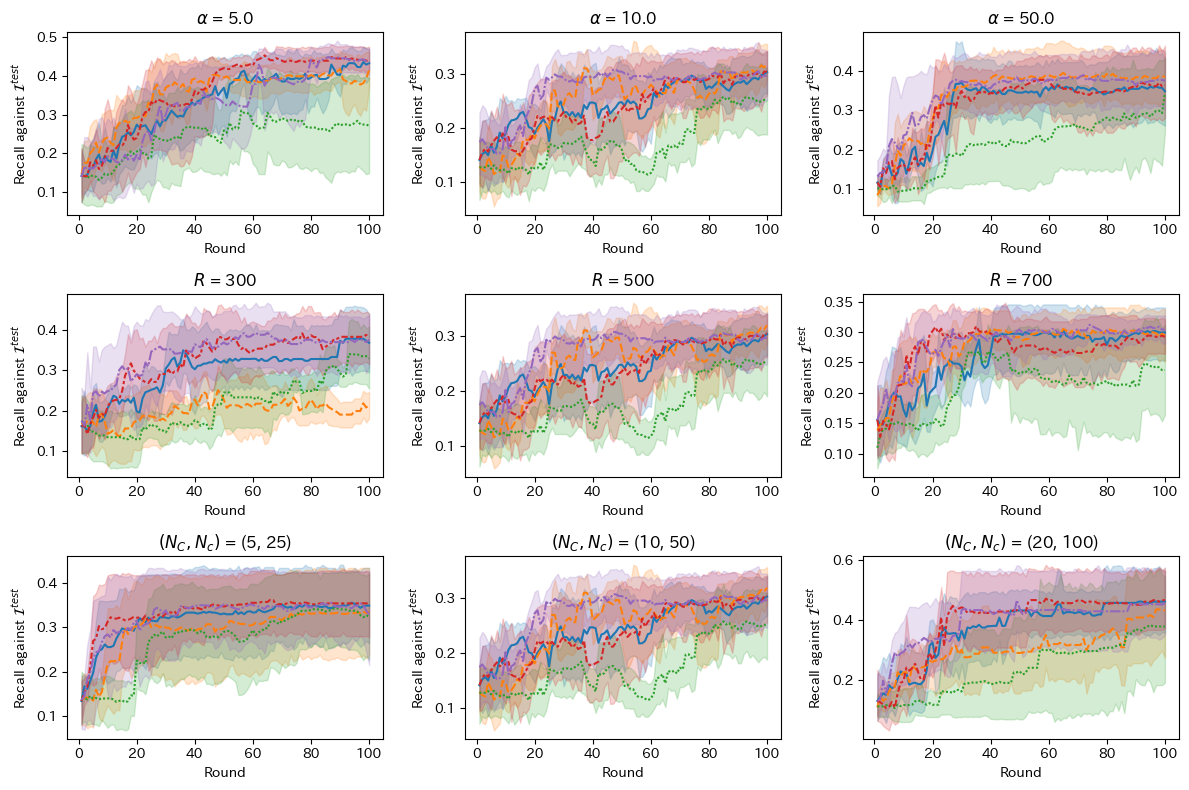

In [ ]:
from lib.const import LANGUANGE_MAP_EN, translate
from lib.util import read_df
import seaborn as sns
import japanize_matplotlib  # noqa: F401
import matplotlib.pyplot as plt

lan_map = LANGUANGE_MAP_EN
_, axes = plt.subplots(nrows=len(log_dirs), ncols=len(log_dirs[0]), figsize=(12, 8))

titles = [
    [f"$\\alpha$ = {alpha}" for alpha in alphas],
    [f"$R$ = {num_sample_item}" for num_sample_item in num_sample_items],
    [f"$(N_C, N_c)$ = ({num_topic[0]}, {num_topic[1]})" for num_topic in num_topics],
]
print(titles)

for i in range(len(log_dirs)):
    for j in range(len(log_dirs[i])):
        sns.lineplot(
            x=translate("round", lan_map),
            y=translate("test-recall", lan_map=lan_map),
            hue=translate("method", lan_map=lan_map),
            style=translate("method", lan_map=lan_map),
            data=read_df(
                log_dirs[i][j] / "log.csv", methods=PREPRINT_METHODS, lan_map=lan_map
            ),
            ax=axes[i, j],
            legend=False,
        )
        axes[i, j].set_title(titles[i][j])

plt.tight_layout()